# Data Pipeline and Exploratory Data Analysis on German COVID-19 DataSet



In this notebook, I build a ETL Pipeline to automatically download and analyze the German Covid-19 Dataset compiled and updated daily by Robert-Koch Institut. Using the downloaded dataset, the notebook performs mainly two tasks: (1) produce the pivot table for number of cases, death, and recoveries per age group and gender from the beginning of Covid-19 in Germany until the most up-to-date reporting date in the dataset; (2) automatically perform an exploratory data analysis (EDA)  for German Covid-19 infection, death and recoveries by many categories: gender, age groups, landkreis (county), and federal state, and produces many beautiful graphs to illustrate the relationships between covid_19 infection and death rate and GDP per capita, age and gender. The underlying dataset is compiled, prepared and validated by Robert-Koch-Institut. 

In [1]:
import os
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style="whitegrid",font='Calibri', font_scale=1.0)

specify the output folder in the working directory to save all output files (csv file, Excel file and Graphics ) from running this notebook. The folder name reflects the date for the day when the notebook is run.

In [2]:
heute=datetime.now()
timedelta=pd.Timedelta('1 day')
report_day=heute-timedelta
report_day=report_day.strftime("%d_%B_%Y")
output_filename="output_"+report_day
if not os.path.exists("./"+output_filename):
    os.makedirs("./"+output_filename)

# 1. the Covid-19 Data Set compiled by Robert-Koch Institute


### 1.1 Import the German Covid-19 Datasets 

The dataset compiled by Robert-Koch Institut can be downloaded from this website 
(https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/explore).

It has been updated on a daily basis. The following lines of code will download the most up-to-date datset each time we run the script.

In [3]:
import urllib.request

url_daily_corona = "https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data"

fname1 = "./"+output_filename+"/RKI_covid19_daily_de.csv"

urllib.request.urlretrieve(url_daily_corona, fname1)

('./output_17_February_2022/RKI_covid19_daily_de.csv',
 <http.client.HTTPMessage at 0x24724547dc8>)

In [4]:

de_corona = pd.read_csv("./"+output_filename+"/RKI_covid19_daily_de.csv", parse_dates=["Meldedatum","Refdatum"])
de_corona=de_corona.set_index("FID")


In [5]:
de_corona.sample(5)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
FID,,,,,,,,,,,,,,,,,
3904964,16,Thüringen,LK Eichsfeld,A35-A59,W,1,0,2021-01-28,16061,"18.02.2022, 00:00 Uhr",0,-9,2021-01-29,0,1,1,Nicht übermittelt
1507069,6,Hessen,SK Kassel,A60-A79,W,1,0,2021-01-09,6611,"18.02.2022, 00:00 Uhr",0,-9,2020-12-31,0,1,1,Nicht übermittelt
1304301,6,Hessen,SK Frankfurt am Main,A60-A79,M,1,0,2021-03-04,6412,"18.02.2022, 00:00 Uhr",0,-9,2021-03-04,0,1,0,Nicht übermittelt
3338633,12,Brandenburg,SK Frankfurt (Oder),A15-A34,M,4,0,2021-11-23,12053,"18.02.2022, 00:00 Uhr",0,-9,2021-11-20,0,4,1,Nicht übermittelt
56472,1,Schleswig-Holstein,LK Pinneberg,A15-A34,W,1,0,2021-01-30,1056,"18.02.2022, 00:00 Uhr",0,-9,2021-01-30,0,1,0,Nicht übermittelt


Transform the values of column "Altersgruppe" into more understandable form.

In [6]:
mapping={'A00-A04':"0-4", 'A05-A14':"5-14", 'A15-A34':"15-34", 'A35-A59':"35-59", 'A60-A79':"60-79", 'A80+':"80+","unbekannt":"unbekannt"}

de_corona["Altersgruppe"]=de_corona["Altersgruppe"].map(mapping)

In [7]:
mapping={"M":"Male","W":"Female","unbekannt":"unbekannt"}
de_corona["Geschlecht"]=de_corona["Geschlecht"].map(mapping)
de_corona.rename(columns={"Geschlecht": "Gender"},inplace=True)

In [8]:
print("the first available date for the RKI-Data set is",de_corona.Meldedatum.min().strftime('%m/%d/%Y'))
print("the last available date for the RKI-Data set is",de_corona["Meldedatum"].max().strftime('%m/%d/%Y'))

the first available date for the RKI-Data set is 01/02/2020
the last available date for the RKI-Data set is 02/17/2022


### 1.2 Descriptions of the RKI Corona Dataset


Beschreibung der Daten des RKI Covid-19 Dataset  (https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6)

Dem Dashboard liegen aggregierte Daten der gemäß IfSG von den Gesundheitsämtern an das RKI übermittelten Covid-19-Fälle zu Grunde
Mit den Daten wird der tagesaktuelle Stand (00:00 Uhr) abgebildet und es werden die Veränderungen bei den Fällen und Todesfällen zum Vortag dargstellt
In der Datenquelle sind folgende Parameter enthalten:

    IdBundesland: Id des Bundeslands des Falles mit 1=Schleswig-Holstein bis 16=Thüringen

    Bundesland: Name des Bundeslanes

    Landkreis ID: Id des Landkreises des Falles in der üblichen Kodierung 1001 bis 16077=LK Altenburger Land

    Landkreis: Name des Landkreises

    Altersgruppe: Altersgruppe des Falles aus den 6 Gruppe 0-4, 5-14, 15-34, 35-59, 60-79, 80+ sowie unbekannt

    Altersgruppe2: Altersgruppe des Falles aus 5-Jahresgruppen 0-4, 5-9, 10-14, ..., 75-79, 80+ sowie unbekannt

    Geschlecht: Geschlecht des Falles M0männlich, W=weiblich und unbekannt

    AnzahlFall: Anzahl der Fälle in der entsprechenden Gruppe

    AnzahlTodesfall: Anzahl der Todesfälle in der entsprechenden Gruppe

    Meldedatum: Datum, wann der Fall dem Gesundheitsamt bekannt geworden ist

    Datenstand: Datum, wann der Datensatz zuletzt aktualisiert worden ist

    NeuerFall: 
        0: Fall ist in der Publikation für den aktuellen Tag und in der für den Vortag enthalten

        1: Fall ist nur in der aktuellen Publikation enthalten

        -1: Fall ist nur in der Publikation des Vortags enthalten
            damit ergibt sich: Anzahl Fälle der aktuellen Publikation als Summe(AnzahlFall), wenn NeuerFall in (0,1); Delta zum Vortag als Summe(AnzahlFall) wenn NeuerFall in (-1,1)

    NeuerTodesfall:
        0: Fall ist in der Publikation für den aktuellen Tag und in der für den Vortag jeweils ein Todesfall
        1: Fall ist in der aktuellen Publikation ein Todesfall, nicht jedoch in der Publikation des Vortages
        -1: Fall ist in der aktuellen Publikation kein Todesfall, jedoch war er in der Publikation des Vortags ein Todesfall
        -9: Fall ist weder in der aktuellen Publikation noch in der des Vortages ein Todesfall
     damit ergibt sich: Anzahl Todesfälle der aktuellen Publikation als Summe(AnzahlTodesfall) wenn NeuerTodesfall in (0,1); Delta zum Vortag als Summe(AnzahlTodesfall) wenn NeuerTodesfall in (-1,1)

    Referenzdatum: Erkrankungsdatum bzw. wenn das nicht bekannt ist, das Meldedatum

    AnzahlGenesen: Anzahl der Genesenen in der entsprechenden Gruppe

    NeuGenesen:
        0: Fall ist in der Publikation für den aktuellen Tag und in der für den Vortag jeweils Genesen
        1: Fall ist in der aktuellen Publikation Genesen, nicht jedoch in der Publikation des Vortages
        -1: Fall ist in der aktuellen Publikation nicht Genesen, jedoch war er in der Publikation des Vortags Genesen
        -9: Fall ist weder in der aktuellen Publikation noch in der des Vortages Genesen 
    damit ergibt sich: Anzahl Genesen der aktuellen Publikation als Summe(AnzahlGenesen) wenn NeuGenesen in (0,1); Delta zum Vortag als Summe(AnzahlGenesen) wenn NeuGenesen in (-1,1)
        
    IstErkrankungsbeginn: 1, wenn das Refdatum der Erkrankungsbeginn ist, 0 sonst

It has to be noted that there is delay or error in Corona Cases reporting on the side of local Health Authorities ( Gesundheitsamt ), therefore Robert Koch-Institut has to revise the dataset retrospectively on a daily basis. In the RKI-dataset, each row denotes the daily new cases for a certain gender, landreis and age group. In the dataset, the daily total number of new cases for a certain day (column "Refdatum") in the past, per gender, Landreis and age group may be split into multiple rows, in order to the show the effects of retrospective revision in comparison to the previous reporting day: the column "AnzahlFall" denotes the number of daily reported new cases for each gender, Landkreis and Age Group; the column "NeuerFall" denotes the category of change in comparion to previous day: if the column "Neuerfall" has a value of 0, this means that value shown in column "AnzahlFall" was already included in the reporting released on the previous reporting day; if the column "Neuerfall" has a value of 1, this means that value shown in column "AnzahlFall" was not included in the reporting released on the previous reporting day, therefore denotes the number of cases newly recorded in the dataset; f the column "Neuerfall" has a value of -1, this means that value shown in column "AnzahlFall" was wrongly included in the reporting released on the previous reporting day, therefore has to be corrected. 


This can be best explained with an example using the table selected from RKI dataset below. For example, in the following table, we select the rows for Landkreis "LK Görlitz", Age Group "A15-A34", and Gender "M" for the Occurence day (2022/02/02) in the dataset: it means that 60+73 cases for the date "2022/02/02" were already reported on 05.02.2022; 6+3 cases for the date "2022/02/02" are just newly reported on 06.02.2022; 10 cases that were reported on the previous day, are not reported as cases any more, probably due to data transfer error. 



In [9]:
de_corona.loc[(de_corona["Landkreis"]=='LK Görlitz')&(de_corona["Altersgruppe"]=='15-34')&(de_corona["Refdatum"]=='2022-02-02'),:]

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Gender,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
FID,,,,,,,,,,,,,,,,,
3673766,14,Sachsen,LK Görlitz,15-34,Male,66,0,2022-02-02,14626,"18.02.2022, 00:00 Uhr",0,-9,2022-02-02,-9,0,0,Nicht übermittelt
3673767,14,Sachsen,LK Görlitz,15-34,Male,1,0,2022-02-02,14626,"18.02.2022, 00:00 Uhr",0,-9,2022-02-02,-9,0,1,Nicht übermittelt
3676979,14,Sachsen,LK Görlitz,15-34,Female,74,0,2022-02-02,14626,"18.02.2022, 00:00 Uhr",0,-9,2022-02-02,-9,0,0,Nicht übermittelt
3676980,14,Sachsen,LK Görlitz,15-34,Female,1,0,2022-02-02,14626,"18.02.2022, 00:00 Uhr",0,-9,2022-02-02,-9,0,1,Nicht übermittelt
3676981,14,Sachsen,LK Görlitz,15-34,Female,1,0,2022-02-03,14626,"18.02.2022, 00:00 Uhr",0,-9,2022-02-02,-9,0,1,Nicht übermittelt
3677008,14,Sachsen,LK Görlitz,15-34,Female,1,0,2022-02-11,14626,"18.02.2022, 00:00 Uhr",0,-9,2022-02-02,-9,0,1,Nicht übermittelt


Therefore in order to calculate the real number of daily cases, we need only to consider the rows where the column "NeuerFall" has value of either 0 or 1; Selecting the rows where the column "NeuerFall" has value of either -1 (decrease) or 1 (increase) will help us find out the change in total number of cases on the reporting day in comparison to the previous reporting day.
 Similarly, to calculate the real number of daily deaths, we need to only consider the rows where the column "NeuerTodesfall" has value of either 0 or 1; to calculate the real number of daily recovery, we need to only consider the rows where the column "NeueGenesen" has value of either 0 or 1. 




By checking the data, I find that the column "AnzahlFall" is always negative when column "NeuerFall" has the value of -1; the column "AnzahlTodesfall" is always negative when column "NeuerTodesFall" has the value of -1; the column "AnzahlGenesen" is always negative when column "NeuGenesen" has the value of -1. 


In [10]:
check_negative_cases=de_corona.loc[de_corona["NeuerFall"].isin([-1]),:]["AnzahlFall"]<0

check_negative_cases.all()


True

In [11]:
check_negative_death=de_corona.loc[de_corona["NeuerTodesfall"].isin([-1]),:]["AnzahlTodesfall"]<0

check_negative_death.all()


True

In [12]:
check_negative_recovery=de_corona.loc[de_corona["NeuGenesen"].isin([-1]),:]["AnzahlGenesen"]<0

check_negative_recovery.all()


True

In order to use the dataframe de_corona to derive the total number of cases, deaths and recoveries, I set the value for column "AnzahlFall" to be zero if the column "NeuerFall" is equal to -1, and set the value for column "AnzahlTodesfall" to be zero if the column "NeuerTodesfall" is equal to -1, and set the value for column "AnzahlGenesen" to be zero if the column "NeueGenesen" is equal to -1. In doing this, for example, we can directly sum up the values in column "AnzahlTodesfall" to get the total number of deaths.

In [13]:
de_covid=de_corona.copy()

de_covid.loc[de_covid["AnzahlFall"]<0,"AnzahlFall"]=0
de_covid.loc[de_covid["AnzahlTodesfall"]<0,"AnzahlTodesfall"]=0
de_covid.loc[de_covid["AnzahlGenesen"]<0,"AnzahlGenesen"]=0

### 1.3 Print the total number of cases and deaths according to the RKI dataset 

In [14]:
print("According to the RKI Dataset, the total number of infections in Germany up to",de_covid.Meldedatum.max().strftime('%m/%d/%Y'),"is",de_covid.AnzahlFall.sum())
  

According to the RKI Dataset, the total number of infections in Germany up to 02/17/2022 is 13255989


In [15]:
print("According to the RKI Dataset,the total number of deaths in Germany up to",de_covid.Meldedatum.max().strftime('%m/%d/%Y'),"is",de_covid.AnzahlTodesfall.sum())

According to the RKI Dataset,the total number of deaths in Germany up to 02/17/2022 is 120992


In [16]:
print("According to the RKI Dataset,the total number of recoveries in Germany up to",de_covid.Meldedatum.max().strftime('%m/%d/%Y'),"is",de_covid.AnzahlGenesen.sum())

According to the RKI Dataset,the total number of recoveries in Germany up to 02/17/2022 is 9484401


The total number of infections and deaths mentioned above in the dataset matches that published in the homepage of Robert-Koch Institut (https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html)

## 2. Explantory Data Analysis: Robert Koch-Institute Covid-19 Dataset

In this section, I perform EDA on the Robert Koch-Institute Covid-19 Dataset and create two tables based on this dataset and import those two tables as analysis results to Excel: table 1 is about the total number of Covid-19 Cases, Deaths and Recoveries by age group and Gender in Germany from the beginning to the most recent reporting day as shown in the dataset; table 2 is an estimation of Covid-19 mortality rates as % of the number of Covid-19 cases by age group and gender.

### 2.1 Plot the monthly development of the total number of corona Cases per age Group in Germany

#### Use the dataframe "cases" to firstly generate a pivot table for the total number of daily cases in Germany, and then downsample it into a dataframe of monthly cases. 

In [17]:
monthly_cases=de_covid.pivot_table(['AnzahlFall'],index="Refdatum",columns="Altersgruppe",aggfunc=sum,margins=False).resample('M').sum()

In [18]:
monthly_cases.head(4)

AnzahlFall                                                      
Altersgruppe        0-4    15-34    35-59    5-14    60-79      80+ unbekannt
Refdatum                                                                     
2020-01-31          7.0     79.0    116.0    28.0     48.0     24.0       0.0
2020-02-29         14.0    348.0    568.0    24.0    198.0     42.0       0.0
2020-03-31        659.0  24137.0  44969.0  1827.0  18710.0   6425.0      22.0
2020-04-30        759.0  16319.0  23814.0  1647.0  12504.0  11945.0      17.0

#### Allocate the number of cases in category of unbekannt to other age groups proportionally.

calculate the percentage of cases for each age group without considering the unbekannt group

In [19]:
rowsum_cases=monthly_cases.iloc[:,0:6].sum(axis = "columns")
rowsum_cases[0:6]

Refdatum
2020-01-31      302.0
2020-02-29     1194.0
2020-03-31    96727.0
2020-04-30    66988.0
2020-05-31    18029.0
2020-06-30    12998.0
Freq: M, dtype: float64

In [20]:
proz_cases=monthly_cases.iloc[:,0:6].div(rowsum_cases,axis="index")
proz_cases.head(4)

AnzahlFall                                                  
Altersgruppe        0-4     15-34     35-59      5-14     60-79       80+
Refdatum                                                                 
2020-01-31     0.023179  0.261589  0.384106  0.092715  0.158940  0.079470
2020-02-29     0.011725  0.291457  0.475712  0.020101  0.165829  0.035176
2020-03-31     0.006813  0.249537  0.464906  0.018888  0.193431  0.066424
2020-04-30     0.011330  0.243611  0.355497  0.024586  0.186660  0.178316

In [21]:
# check the sum of proportions along the columns is equal to 100%
proz_cases.sum(axis="columns")

Refdatum
2020-01-31    1.0
2020-02-29    1.0
2020-03-31    1.0
2020-04-30    1.0
2020-05-31    1.0
2020-06-30    1.0
2020-07-31    1.0
2020-08-31    1.0
2020-09-30    1.0
2020-10-31    1.0
2020-11-30    1.0
2020-12-31    1.0
2021-01-31    1.0
2021-02-28    1.0
2021-03-31    1.0
2021-04-30    1.0
2021-05-31    1.0
2021-06-30    1.0
2021-07-31    1.0
2021-08-31    1.0
2021-09-30    1.0
2021-10-31    1.0
2021-11-30    1.0
2021-12-31    1.0
2022-01-31    1.0
2022-02-28    1.0
Freq: M, dtype: float64

allocate the number of cases falling in the group "unbekannt" into other age groups per week.

In [22]:
monthly_cases_alloc=round(proz_cases.multiply(monthly_cases.iloc[:,0:6],axis="index")+monthly_cases.iloc[:,0:6])
monthly_cases_alloc.head()


AnzahlFall                                            
Altersgruppe        0-4    15-34    35-59    5-14    60-79      80+
Refdatum                                                           
2020-01-31          7.0    100.0    161.0    31.0     56.0     26.0
2020-02-29         14.0    449.0    838.0    24.0    231.0     43.0
2020-03-31        663.0  30160.0  65875.0  1862.0  22329.0   6852.0
2020-04-30        768.0  20294.0  32280.0  1687.0  14838.0  14075.0
2020-05-31        508.0   7144.0   8737.0   995.0   2993.0   2294.0

#### plot the percentage stacked area chart 

In [23]:

monthly_cases_alloc.index

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28'],
              dtype='datetime64[ns]', name='Refdatum', freq='M')

In [24]:
# change the index of the dataframe "monthly_cases_allocated" into date format instead of datetime format.
monthly_cases_alloc.index=monthly_cases_alloc.index.date

In [25]:
# calculate percentage distribution across age groups of monthly cases
perc = monthly_cases_alloc.divide(monthly_cases_alloc.sum(axis=1), axis=0)
perc.head()

AnzahlFall                                                  
Altersgruppe        0-4     15-34     35-59      5-14     60-79       80+
2020-01-31     0.018373  0.262467  0.422572  0.081365  0.146982  0.068241
2020-02-29     0.008755  0.280801  0.524078  0.015009  0.144465  0.026892
2020-03-31     0.005190  0.236103  0.515692  0.014576  0.174799  0.053640
2020-04-30     0.009149  0.241762  0.384551  0.020097  0.176765  0.167675
2020-05-31     0.022407  0.315116  0.385382  0.043889  0.132019  0.101187

In [26]:
timestep=perc.index.to_list()
timestep

[datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 29),
 datetime.date(2020, 3, 31),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 5, 31),
 datetime.date(2020, 6, 30),
 datetime.date(2020, 7, 31),
 datetime.date(2020, 8, 31),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 10, 31),
 datetime.date(2020, 11, 30),
 datetime.date(2020, 12, 31),
 datetime.date(2021, 1, 31),
 datetime.date(2021, 2, 28),
 datetime.date(2021, 3, 31),
 datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 31),
 datetime.date(2021, 6, 30),
 datetime.date(2021, 7, 31),
 datetime.date(2021, 8, 31),
 datetime.date(2021, 9, 30),
 datetime.date(2021, 10, 31),
 datetime.date(2021, 11, 30),
 datetime.date(2021, 12, 31),
 datetime.date(2022, 1, 31),
 datetime.date(2022, 2, 28)]

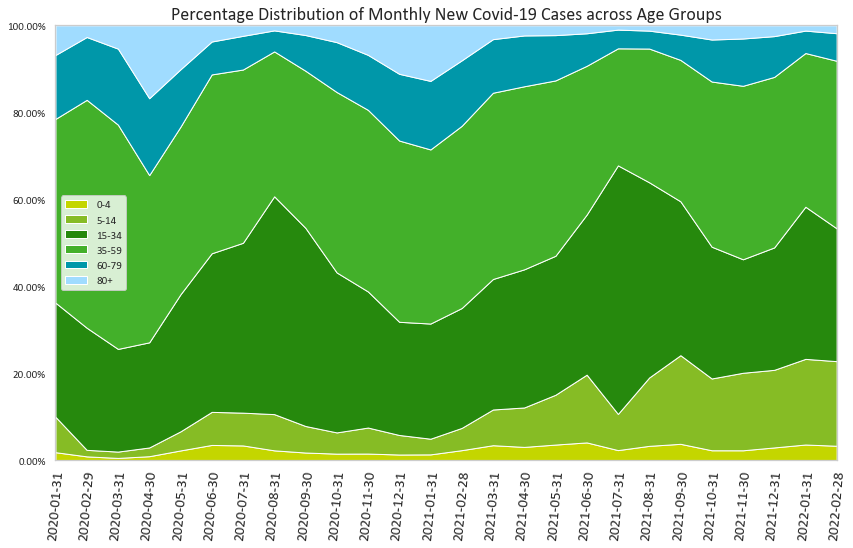

<Figure size 432x288 with 0 Axes>

In [27]:
fig, ax = plt.subplots(1,1,figsize=(14,8)) 
color_map = ['#C4D600',"#86BC25", "#26890D","#43B02A","#0097A9","#A0DCFF","#007CB0","#63666A"]
ax.stackplot(range(1,len(perc)+1),  perc["AnzahlFall","0-4"],  perc["AnzahlFall","5-14"],  perc["AnzahlFall","15-34"],perc["AnzahlFall","35-59"],perc["AnzahlFall","60-79"],perc["AnzahlFall","80+"],labels=["0-4","5-14",
"15-34","35-59","60-79","80+"], colors = color_map)
plt.legend(loc='center left')
plt.margins(0,0)
plt.title('Percentage Distribution of Monthly New Covid-19 Cases across Age Groups',fontname='Calibri', fontsize=18)

ax.set_xticks(range(1,len(perc)+1))
ax.set_xticklabels(timestep, rotation=85, fontsize=15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_formatter(PercentFormatter(1,decimals=2))
plt.show()
plt.tight_layout()
ax.figure.savefig("./"+output_filename+"/weekly_age_distribution.png",dpi=400,bbox_inches = 'tight')

### 2.2  Plot the total number of Cases, Deaths, and Recoveries by Bundesland

In [28]:
state_corona=de_covid.groupby(["Bundesland"])["AnzahlFall","AnzahlTodesfall","AnzahlGenesen"].agg(sum).reset_index().sort_values(by ='AnzahlFall', ascending=True)
state_corona

C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Bundesland,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
4,Bremen,107619,671,89335
11,Saarland,141475,1369,104103
7,Mecklenburg-Vorpommern,205392,1714,154374
14,Schleswig-Holstein,285433,2068,196409
5,Hamburg,327925,2249,211616
13,Sachsen-Anhalt,354727,4699,261584
15,Thüringen,373510,6528,320091
3,Brandenburg,463750,5117,307772
10,Rheinland-Pfalz,517253,4915,353700
2,Berlin,678339,4205,468830


In [29]:
state_corona["AnzahlAktiv"]=state_corona["AnzahlFall"]-state_corona["AnzahlTodesfall"]-state_corona["AnzahlGenesen"]
state_corona.set_index("Bundesland",inplace=True)

In [30]:
land_corona=state_corona.loc[:,["AnzahlAktiv","AnzahlGenesen","AnzahlTodesfall"]]

land_corona.rename(columns={"AnzahlAktiv":"Active Cases","AnzahlGenesen":"Recoveries","AnzahlTodesfall":"Deaths"},inplace=True)

In [31]:
land_corona

,Active Cases,Recoveries,Deaths
Bundesland,,,
Bremen,17613,89335,671
Saarland,36003,104103,1369
Mecklenburg-Vorpommern,49304,154374,1714
Schleswig-Holstein,86956,196409,2068
Hamburg,114060,211616,2249
Sachsen-Anhalt,88444,261584,4699
Thüringen,46891,320091,6528
Brandenburg,150861,307772,5117
Rheinland-Pfalz,158638,353700,4915


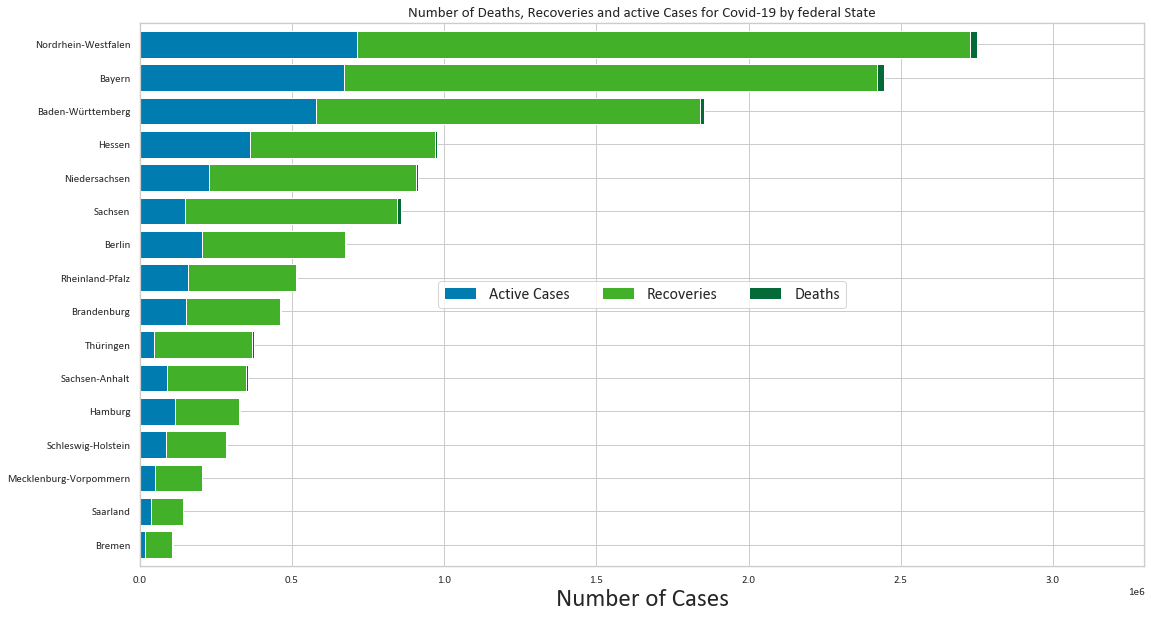

In [32]:
fig = plt.figure(figsize=(18, 10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)


ax=fig.add_subplot(1,1,1)
ax=land_corona.plot(ax=ax,kind='barh',stacked=True,color = ["#007CB0","#43B02A","#046A38"],width=0.8,label="Perfect")
ax.legend(ncol=3, loc="center", frameon=True,fontsize=16)
   
ax.set(xlim=(0, 1.2*state_corona.AnzahlFall.max()))

ax.set_xlabel("Number of Cases",fontsize = 25, fontname="Calibri")
ax.set_ylabel("",fontsize = 15)

plt.title("Number of Deaths, Recoveries and active Cases for Covid-19 by federal State" , fontname='Calibri', fontsize = 15)
fig.savefig("./"+output_filename+"/cases_split_bundesland.png",bbox_inches='tight')

### 2.3 plot the death rate as % of the number of cases by Age Group and Gender

In [33]:
age_corona=de_covid.pivot_table(['AnzahlFall',"AnzahlTodesfall","AnzahlGenesen"],index="Altersgruppe",columns="Gender",aggfunc=sum,margins=False)
age_corona

AnzahlFall                    AnzahlGenesen                     \
Gender           Female     Male unbekannt        Female     Male unbekannt   
Altersgruppe                                                                  
0-4              219690   235286      9781        148801   159584      5100   
15-34           2013697  1954763     39497       1450773  1438614     23089   
35-59           2452894  2266976     39328       1770200  1660191     21926   
5-14            1015523  1116325     37593        661620   724360     19375   
60-79            664981   654398      7376        521070   504317      4496   
80+              331682   182154      2424        243587   119823      1412   
unbekannt          4634     4620      2367          2421     2526      1116   

             AnzahlTodesfall                   
Gender                Female   Male unbekannt  
Altersgruppe                                   
0-4                       14      8         0  
15-34                    136    211         1  
35-59                   1891   4483        15  
5-14                      12     11         0  
60-79                  12899  24186        60  
80+                    41423  35523       110  
unbekannt                  4      3         2

I write an function for the allocate the unkown number of infection, deaths, and recoveries for unkown groups of Gender and Age groups to the known groups according to the corresponding percentages.

In [34]:
def allocat_unbekannt(df):
    
    # create a pivot table for total number of cases, deaths, and recoveries by age groups and gender
    age_corona=df.pivot_table(['AnzahlFall',"AnzahlTodesfall","AnzahlGenesen"],index="Altersgruppe",columns="Gender",aggfunc=sum,margins=False)

    # slice the total number of cases, death, recovereis for male and female from the pivot table
    idx=pd.IndexSlice
    bekannt=age_corona.loc[:,idx[:,['Male','Female']]]

    # slice the total number of cases, death, recovereis for unbekannt gender from the pivot table 
    unbekannt=age_corona.loc[:,idx[:,['unbekannt']]]
 
    # calculate the percentage share between male and female for cases, death, recovereis by age group
    share=bekannt.div(bekannt.groupby(level=0,axis=1).sum(), level=0, axis=0)
    
    unbekannt.columns=["AnzahlFall","AnzahlGenesen","AnzahlTodesfall"]

    # allocate the allocated number of cases, death, recovereis in the "unbekannt" gender ctegory into the male and female category according to the percentages calculated above.
    alloc_gender=share.multiply(unbekannt, axis=0,level=0)


    # calculate the total number of cases, death, recovereis afer allocating the "unbekannt" gender category into the male and female category according to the percentages calculated above.
    bekannt_alloc_gender=round(alloc_gender + bekannt)



    # slice the total number of cases, death, recovereis for bekannt and unbekannt age category from the pivot table 
    age_clear=bekannt_alloc_gender.loc["0-4":"80+",:]
    age_unclear=bekannt_alloc_gender.loc["unbekannt",:]


    # calculate the percentage share among different age groups for cases, death, recovereis by gender
    share_rows=age_clear.div(age_clear.groupby(axis=0,level=0).sum(),axis=1,level=0)
    
     # calculate the total number of cases, death, recovereis after allocating in the "unbekannt" age category into other age category according to the percentages calculated above.
    age_corona_alloc=round(share_rows.multiply(age_unclear,axis=1,level=0)+age_clear)


     #calculate the number of active cases and death rate by age group and gender 
    age_corona_alloc=age_corona_alloc.stack().reset_index()
    age_corona_alloc.loc[:,"AnzahlAktive"]=age_corona_alloc.loc[:,"AnzahlFall"]-age_corona_alloc.loc[:,"AnzahlTodesfall"]-age_corona_alloc.loc[:,"AnzahlGenesen"]
    age_corona_alloc.loc[:,"death_rate"]=age_corona_alloc.loc[:,"AnzahlTodesfall"]/(age_corona_alloc.loc[:,"AnzahlFall"]-age_corona_alloc.loc[:,"AnzahlAktive"])


    return age_corona_alloc
    
    
    


In [35]:
age_corona_alloc=allocat_unbekannt(de_covid)

In [36]:
age_corona_alloc

,Altersgruppe,Gender,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate
0,0-4,Female,230232.0,154229.0,19.0,75984.0,0.000123
1,0-4,Male,246146.0,165319.0,12.0,80815.0,0.000073
2,15-34,Female,2039558.0,1465333.0,141.0,574084.0,0.000096
3,15-34,Male,1980020.0,1453206.0,216.0,526598.0,0.000149
4,35-59,Female,2479152.0,1784482.0,1900.0,692770.0,0.001064
5,35-59,Male,2291667.0,1673898.0,4498.0,613271.0,0.002680
6,5-14,Female,1039250.0,673836.0,17.0,365397.0,0.000025
7,5-14,Male,1141812.0,737582.0,15.0,404215.0,0.000020
8,60-79,Female,674518.0,526322.0,12925.0,135271.0,0.023969
9,60-79,Male,663858.0,509624.0,24229.0,130005.0,0.045385


In [37]:
age_corona_alloc.loc[:,"Altersgruppe"]= pd.Categorical(age_corona_alloc["Altersgruppe"], ordered=True, categories=['0-4', '5-14', '15-34', '35-59', '60-79', '80+'])

age_corona_alloc.sort_values("Altersgruppe",inplace=True)
age_corona_alloc

,Altersgruppe,Gender,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate
0,0-4,Female,230232.0,154229.0,19.0,75984.0,0.000123
1,0-4,Male,246146.0,165319.0,12.0,80815.0,0.000073
6,5-14,Female,1039250.0,673836.0,17.0,365397.0,0.000025
7,5-14,Male,1141812.0,737582.0,15.0,404215.0,0.000020
2,15-34,Female,2039558.0,1465333.0,141.0,574084.0,0.000096
3,15-34,Male,1980020.0,1453206.0,216.0,526598.0,0.000149
4,35-59,Female,2479152.0,1784482.0,1900.0,692770.0,0.001064
5,35-59,Male,2291667.0,1673898.0,4498.0,613271.0,0.002680
8,60-79,Female,674518.0,526322.0,12925.0,135271.0,0.023969
9,60-79,Male,663858.0,509624.0,24229.0,130005.0,0.045385


plot the death rate as % of the infected cases by gender and age group

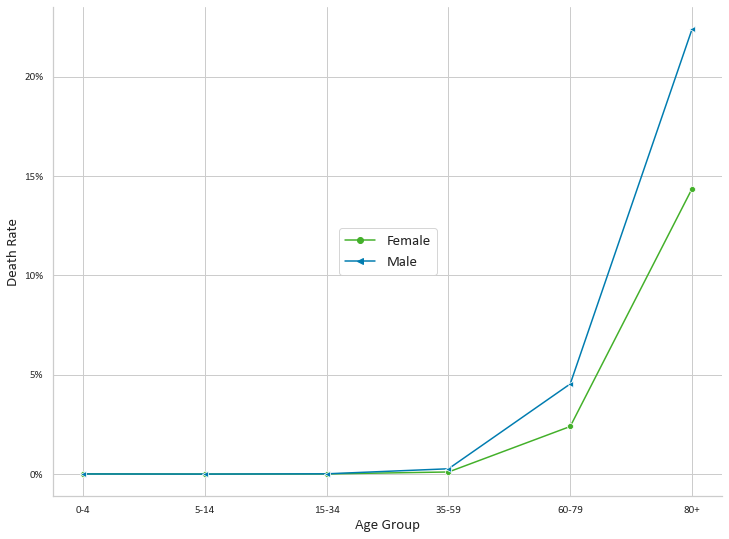

In [38]:
plt.figure(figsize= (12,9))

colors = ["#43B02A","#007CB0"]
#sns.palplot(sns.color_palette(flatui))

ax=sns.lineplot(x = "Altersgruppe", y = "death_rate", data = age_corona_alloc, hue = "Gender",style = "Gender", 
              palette=sns.color_palette(colors, n_colors=2), dashes = False, markers = ["o", "<"],  legend="brief",sort=True)

ax.yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
sns.despine()
 
plt.title("", fontsize = 15,fontname="Calibri") # for title
plt.xlabel("Age Group", fontsize = 15) # label for x-axis
plt.ylabel("Death Rate", fontsize = 15) # label for y-axis
plt.legend(loc="center",fontsize=15)
plt.show()

ax.figure.savefig("./"+output_filename+"/death_Age_gender.png",dpi=400)

Create a Pivot Table for the most up-to-date total number of cases, deaths, and recoveries in Germany by age group and gender. This pivot table will be imported to an sheet in excel file.

In [39]:
age_corona_total=age_corona_alloc.pivot_table(index="Altersgruppe",columns=["Gender"], values=["AnzahlFall","AnzahlGenesen","AnzahlTodesfall"],aggfunc=sum)

age_corona_total

AnzahlFall            AnzahlGenesen            AnzahlTodesfall  \
Gender           Female       Male        Female       Male          Female   
Altersgruppe                                                                  
0-4            230232.0   246146.0      154229.0   165319.0            19.0   
5-14          1039250.0  1141812.0      673836.0   737582.0            17.0   
15-34         2039558.0  1980020.0     1465333.0  1453206.0           141.0   
35-59         2479152.0  2291667.0     1784482.0  1673898.0          1900.0   
60-79          674518.0   663858.0      526322.0   509624.0         12925.0   
80+            339066.0   188815.0      247500.0   123385.0         41487.0   

                       
Gender           Male  
Altersgruppe           
0-4              12.0  
5-14             15.0  
15-34           216.0  
35-59          4498.0  
60-79         24229.0  
80+           35578.0

### 2.4. Perform the German Covid-19 Mortality Rate Estimation Per Age Group and Gender and Export the mortality table to excel

In order to estimate mortality rates (as the number of death divided by the number of cases) using the RKI Dataset, we have to exclude the number of active cases from the number of cases, since the final outcome for those active cases are still unknown, it could be either death or recovery. The outcome of a covid-19 case becomes known usually within one month. Therefore I select all the rows in the RKI dataset, where the date of occurence lies 4 weeks before the current reporting date. By doing this, we can obtain a rather accurate estimate of mortality rate, free from the effects of active cases in the dataset.

In [40]:

timedelta=pd.Timedelta('28 days')
de_covid_select=de_covid.loc[de_covid["Refdatum"]<=(de_covid["Meldedatum"].max()-timedelta),:]
de_covid_select.sample(5)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Gender,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
FID,,,,,,,,,,,,,,,,,
2802937,9,Bayern,SK Nürnberg,60-79,Male,2,2,2020-04-07,9564,"18.02.2022, 00:00 Uhr",0,0,2020-04-06,-9,0,1,Nicht übermittelt
2963443,9,Bayern,LK Würzburg,60-79,Female,1,0,2020-08-05,9679,"18.02.2022, 00:00 Uhr",0,-9,2020-07-31,0,1,1,Nicht übermittelt
529378,5,Nordrhein-Westfalen,SK Duisburg,5-14,Male,4,0,2021-01-10,5112,"18.02.2022, 00:00 Uhr",0,-9,2021-01-10,0,4,0,Nicht übermittelt
270973,3,Niedersachsen,LK Hameln-Pyrmont,15-34,Male,1,0,2021-11-23,3252,"18.02.2022, 00:00 Uhr",0,-9,2021-11-24,0,1,1,Nicht übermittelt
188119,3,Niedersachsen,LK Goslar,5-14,Female,1,0,2022-01-17,3153,"18.02.2022, 00:00 Uhr",0,-9,2022-01-16,0,1,1,Nicht übermittelt


In [41]:
adjusted_mortality=allocat_unbekannt(de_covid_select)

In [42]:
adjusted_mortality

,Altersgruppe,Gender,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate
0,0-4,Female,131931.0,131914.0,17.0,0.0,0.000129
1,0-4,Male,141324.0,141314.0,10.0,0.0,0.000071
2,15-34,Female,1309732.0,1309596.0,135.0,1.0,0.000103
3,15-34,Male,1310006.0,1309798.0,208.0,0.0,0.000159
4,35-59,Female,1607744.0,1605869.0,1871.0,4.0,0.001164
5,35-59,Male,1518414.0,1513966.0,4437.0,11.0,0.002922
6,5-14,Female,566993.0,566978.0,15.0,0.0,0.000026
7,5-14,Male,617605.0,617592.0,11.0,2.0,0.000018
8,60-79,Female,506607.0,493911.0,12705.0,-9.0,0.025078
9,60-79,Male,501625.0,477700.0,23898.0,27.0,0.047644


In [43]:
adjusted_mortality=adjusted_mortality.pivot_table(values=['AnzahlFall', 'AnzahlGenesen', 'AnzahlTodesfall', 'death_rate'], index="Altersgruppe",columns="Gender",aggfunc=sum,margins=True)
adjusted_mortality

AnzahlFall                       AnzahlGenesen             \
Gender           Female       Male        All        Female       Male   
Altersgruppe                                                             
0-4            131931.0   141324.0   273255.0      131914.0   141314.0   
15-34         1309732.0  1310006.0  2619738.0     1309596.0  1309798.0   
35-59         1607744.0  1518414.0  3126158.0     1605869.0  1513966.0   
5-14           566993.0   617605.0  1184598.0      566978.0   617592.0   
60-79          506607.0   501625.0  1008232.0      493911.0   477700.0   
80+            276804.0   151846.0   428650.0      236074.0   116904.0   
All           4399811.0  4240820.0  8640631.0     4344342.0  4177274.0   

                        AnzahlTodesfall                    death_rate  \
Gender              All          Female     Male       All     Female   
Altersgruppe                                                            
0-4            273228.0            17.0     10.0      27.0   0.000129   
15-34         2619394.0           135.0    208.0     343.0   0.000103   
35-59         3119835.0          1871.0   4437.0    6308.0   0.001164   
5-14          1184570.0            15.0     11.0      26.0   0.000026   
60-79          971611.0         12705.0  23898.0   36603.0   0.025078   
80+            352978.0         40739.0  34912.0   75651.0   0.147172   
All           8521616.0         55482.0  63476.0  118958.0   0.173672   

                                  
Gender            Male       All  
Altersgruppe                      
0-4           0.000071  0.000200  
15-34         0.000159  0.000262  
35-59         0.002922  0.004086  
5-14          0.000018  0.000044  
60-79         0.047644  0.072722  
80+           0.229963  0.377134  
All           0.280776  0.454448

the column (death_rate,All) is not the average death rate for all the cases that, instead it is the sum of the death rate, therefore we have to create a separate column for the average death rate for all cases

In [44]:
adjusted_mortality.loc[:,("death_rate","All")]=adjusted_mortality.loc[:,("AnzahlTodesfall","All")]/adjusted_mortality.loc[:,("AnzahlFall","All")]



Similarly, the death rate for Female and Male shown in the last row has also to be revised.

In [45]:
adjusted_mortality.loc["All",("death_rate","Male")]=adjusted_mortality.loc["All",("AnzahlTodesfall","Male")]/adjusted_mortality.loc["All",("AnzahlFall","Male")]

adjusted_mortality.loc["All",("death_rate","Female")]=adjusted_mortality.loc["All",("AnzahlTodesfall","Female")]/adjusted_mortality.loc["All",("AnzahlFall","Female")]

In [46]:
adjusted_mortality

AnzahlFall                       AnzahlGenesen             \
Gender           Female       Male        All        Female       Male   
Altersgruppe                                                             
0-4            131931.0   141324.0   273255.0      131914.0   141314.0   
15-34         1309732.0  1310006.0  2619738.0     1309596.0  1309798.0   
35-59         1607744.0  1518414.0  3126158.0     1605869.0  1513966.0   
5-14           566993.0   617605.0  1184598.0      566978.0   617592.0   
60-79          506607.0   501625.0  1008232.0      493911.0   477700.0   
80+            276804.0   151846.0   428650.0      236074.0   116904.0   
All           4399811.0  4240820.0  8640631.0     4344342.0  4177274.0   

                        AnzahlTodesfall                    death_rate  \
Gender              All          Female     Male       All     Female   
Altersgruppe                                                            
0-4            273228.0            17.0     10.0      27.0   0.000129   
15-34         2619394.0           135.0    208.0     343.0   0.000103   
35-59         3119835.0          1871.0   4437.0    6308.0   0.001164   
5-14          1184570.0            15.0     11.0      26.0   0.000026   
60-79          971611.0         12705.0  23898.0   36603.0   0.025078   
80+            352978.0         40739.0  34912.0   75651.0   0.147172   
All           8521616.0         55482.0  63476.0  118958.0   0.012610   

                                  
Gender            Male       All  
Altersgruppe                      
0-4           0.000071  0.000099  
15-34         0.000159  0.000131  
35-59         0.002922  0.002018  
5-14          0.000018  0.000022  
60-79         0.047644  0.036304  
80+           0.229963  0.176487  
All           0.014968  0.013767

Import the two dataframes "adjusted_mortality" in section 2.4 and "age_corona_total" in section 2.3 into exel

In [47]:
fourweeksago=de_covid_select.Refdatum.max().strftime("%d-%m-%Y")
sheetname = "AdjustedDeathRate_"+ fourweeksago 

In [48]:
with pd.ExcelWriter("German_Covid_19_Mortality_Infection.xlsx") as writer:
    adjusted_mortality.to_excel(writer,sheet_name=sheetname,startrow=0,startcol=0)
    age_corona_total.to_excel(writer,sheet_name="Covid_19_Cases_Death",startrow=0,startcol=0)

## 3. Analyzing the correlations between Corona infections and deaths with landkreis-specific characteristics.
The following five datasets are collected and preprocessed from reliable sources. They provide mostly landkreis-specific characteristics. Also quality assurance is applied on these dataset. 


### 3.1 Merge the four landkreis-specific datasets with RKI Dataset

The dataset "GDP_landkreise" (updated in August 2018) comes from German Statistisches Bundesamt and it provides GDP per capita and GDP per Employee for each and every landkreis in Germany. The dataset "population_DE.xlsx" (updated in 2020) comes from German Statistisches Bundesamt. The dataset "age_landkreis.xlsx" comes from Statistische Ämter des Bundes und der Länder (2020).
The dataset "geo" comes from the following website: https://data.opendatasoft.com/explore/dataset/georef-germany-kreis%40public/export/?disjunctive.lan_code&disjunctive.lan_name&disjunctive.krs_code&disjunctive.krs_name&disjunctive.krs_name_short


In [49]:

age = pd.read_excel("age_Landkreis.xlsx",sheet_name="AvgAge_landkreise",engine='openpyxl',index_col="Landkreis")
population = pd.read_excel("population_DE.xlsx",sheet_name="population_age",engine='openpyxl',index_col="Landkreis")

geo=pd.read_excel("Geo_Data_Landkreise.xlsx",sheet_name="geo_landkreis",engine='openpyxl',index_col="Landkreis")
gdp=pd.read_excel('GDP_landkreise.xlsx',sheet_name="average_gdp",engine='openpyxl',index_col="Landkreis")

Since the index set of dataframe "age" and "gdp" are equal (401), and smaller in size than the index set of dataframe "gdp" and "geo" (403), and both the elements of index set of "age" and "gdp" are contained in the index set of dataframe "gdp" and "geo", therefore I can directly use concatenation along the columns to merge the fours dataframes.

In [50]:
set(geo.index)==set(population.index) and set(age.index) ==set(gdp.index) and age.index.shape<geo.index.shape and set(age.index).issubset(geo.index) and set(gdp.index).issubset(geo.index)

True

In [51]:
landkreise=pd.concat([age,population,geo,gdp],axis=1)
landkreise.index.name="Landkreis"
landkreise.head()

,Avg_Age,Avg_Age_M,Avg_Age_F,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Geo,ID,landkreis_ID,BIP je Kopf,BIP je Berufstätig
Landkreis,,,,,,,,,,,,,,
LK Ahrweiler,46.5,45.1,47.8,129727.0,63755.0,65972.0,9458.0,14696.0,17109.0,"50.4675853221, 7.04497643896",297,7131.0,26035.0,62499.0
LK Aichach-Friedberg,43.5,42.5,44.5,133596.0,66651.0,66945.0,8447.0,12853.0,13631.0,"48.4275701484, 11.0527555565",46,9771.0,27138.0,64912.0
LK Alb-Donau-Kreis,43,41.9,44.2,196047.0,99041.0,97006.0,12811.0,17832.0,19888.0,"48.4017114301, 9.82744714375",1,8425.0,30683.0,74434.0
LK Altenburger Land,50.1,48.4,51.8,90118.0,44138.0,45980.0,7665.0,12669.0,14672.0,"50.9564246614, 12.3991313423",381,16077.0,22321.0,56640.0
LK Altenkirchen,45.2,43.8,46.5,128705.0,63859.0,64846.0,9255.0,13742.0,14952.0,"50.750747657, 7.74412525976",298,7132.0,27553.0,63371.0


Merge the dataframe "landkreise" with the RKI corona dataset "de_covid" using the column "Landkreis" as key

In [52]:
landkreise.reset_index(inplace=True)

Check the datatypes of the merged dataframs "landkreise": the columns "Avg_Age", "Avg_Age_M", and "Avg_Age_F" should be numeric features, but they contain string values. 

In [53]:
landkreise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Landkreis              403 non-null    object 
 1   Avg_Age                401 non-null    object 
 2   Avg_Age_M              401 non-null    object 
 3   Avg_Age_F              401 non-null    object 
 4   gesamt_popu            401 non-null    float64
 5   male_popu              401 non-null    float64
 6   female_popu            401 non-null    float64
 7   60 bis unter 65 Jahre  401 non-null    float64
 8   65 bis unter 75 Jahre  401 non-null    float64
 9   75 Jahre und mehr      401 non-null    float64
 10  Geo                    403 non-null    object 
 11  ID                     403 non-null    int64  
 12  landkreis_ID           401 non-null    float64
 13  BIP je Kopf            401 non-null    float64
 14  BIP je Berufstätig     401 non-null    float64
dtypes: flo

The reasons that the columns "Avg_Age", "Avg_Age_M", and "Avg_Age_F" have a datatype "object" is due to the fact they contain  string value "_", as shown below. That can be set to "na" by using pd.to_numeric() method.

In [54]:
landkreise["Avg_Age"].unique()

array([46.5, 43.5, 43, 50.1, 45.2, 47.3, 44.6, 44.2, 45, 45.1, 49.1, 43.9,
       46.7, 46.6, 45.7, 43.7, '-', 48.3, 45.3, 42.5, 46.4, 44.4, 43.2,
       44.8, 47, 44.5, 49, 40.8, 46, 42.7, 44.1, 46.2, 43.6, 45.8, 42,
       42.8, 46.1, 42.2, 44, 48.9, 44.3, 41.3, 45.4, 46.9, 45.5, 46.3,
       47.9, 50, 43.4, 43.3, 46.8, 44.7, 47.6, 45.6, 47.1, 48.2, 42.9,
       47.2, 48.7, 44.9, 43.1, 45.9, 48, 48.4, 47.5, 47.7, 43.8, 42.1,
       49.6, 47.8, 47.4, 48.1, 49.5, 42.6, 41.6, 48.5, 50.2, 41.4, 42.4,
       40.5, 48.8, 40.4, 41.9, 50.7, 41.7, 41.2, nan], dtype=object)

In [55]:
landkreise["Avg_Age"]= pd.to_numeric(landkreise["Avg_Age"], errors='coerce')
landkreise["Avg_Age_F"]= pd.to_numeric(landkreise["Avg_Age_F"], errors='coerce')
landkreise["Avg_Age_M"]= pd.to_numeric(landkreise["Avg_Age_M"], errors='coerce')

In [56]:
landkreise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Landkreis              403 non-null    object 
 1   Avg_Age                382 non-null    float64
 2   Avg_Age_M              382 non-null    float64
 3   Avg_Age_F              382 non-null    float64
 4   gesamt_popu            401 non-null    float64
 5   male_popu              401 non-null    float64
 6   female_popu            401 non-null    float64
 7   60 bis unter 65 Jahre  401 non-null    float64
 8   65 bis unter 75 Jahre  401 non-null    float64
 9   75 Jahre und mehr      401 non-null    float64
 10  Geo                    403 non-null    object 
 11  ID                     403 non-null    int64  
 12  landkreis_ID           401 non-null    float64
 13  BIP je Kopf            401 non-null    float64
 14  BIP je Berufstätig     401 non-null    float64
dtypes: flo

Before we merge the dataframe "landkreise" with the RKI dataset "de_covid" on the column "Landkreis", it is necessary to check if some landreis have different names in two datasets.

In [57]:

set(landkreise["Landkreis"]).difference(set(de_covid["Landkreis"]))

{'Bodensee',
 'LK Osterode am Harz',
 'LK Saar-Pfalz-Kreis',
 'SK Berlin',
 'SK Eisenach',
 'StadtRegion Aachen'}

In [58]:
set(de_covid["Landkreis"]).difference(set(landkreise["Landkreis"]))

{'LK Saarpfalz-Kreis',
 'SK Berlin Charlottenburg-Wilmersdorf',
 'SK Berlin Friedrichshain-Kreuzberg',
 'SK Berlin Lichtenberg',
 'SK Berlin Marzahn-Hellersdorf',
 'SK Berlin Mitte',
 'SK Berlin Neukölln',
 'SK Berlin Pankow',
 'SK Berlin Reinickendorf',
 'SK Berlin Spandau',
 'SK Berlin Steglitz-Zehlendorf',
 'SK Berlin Tempelhof-Schöneberg',
 'SK Berlin Treptow-Köpenick',
 'StädteRegion Aachen'}

By comparing the differences of the elements contained in the column "Landkreis" of the two datasets, we have to make the following changes to ensure consistency when we merge the two datasets on the column "Landkreis".

In [59]:
de_covid.loc[de_covid["Landkreis"].str.contains("SK Berlin"),"Landkreis"]="SK Berlin"

In [60]:
de_covid.loc[de_covid["Landkreis"]=="LK Saarpfalz-Kreis","Landkreis"]="LK Saar-Pfalz-Kreis"

In [61]:
landkreise.loc[landkreise["Landkreis"]=="StadtRegion Aachen","Landkreis"]="StädteRegion Aachen"

In [62]:
covid_landkreis=de_covid.merge(landkreise,how="outer",on=["Landkreis"])
covid_landkreis.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Gender,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,Avg_Age,Avg_Age_M,Avg_Age_F,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Geo,ID,landkreis_ID,BIP je Kopf,BIP je Berufstätig
0,1.0,Schleswig-Holstein,SK Flensburg,5-14,Female,1.0,0.0,2021-11-13,1001.0,"18.02.2022, 00:00 Uhr",0.0,-9.0,2021-11-13,0.0,1.0,0.0,Nicht übermittelt,42.4,41.1,43.7,89504.0,44599.0,44905.0,5061.0,8525.0,9463.0,"54.7849933768, 9.43852835486",367,1001.0,42751.0,62665.0
1,1.0,Schleswig-Holstein,SK Flensburg,5-14,Female,1.0,0.0,2021-11-14,1001.0,"18.02.2022, 00:00 Uhr",0.0,-9.0,2021-11-14,0.0,1.0,1.0,Nicht übermittelt,42.4,41.1,43.7,89504.0,44599.0,44905.0,5061.0,8525.0,9463.0,"54.7849933768, 9.43852835486",367,1001.0,42751.0,62665.0
2,1.0,Schleswig-Holstein,SK Flensburg,5-14,Female,1.0,0.0,2021-11-15,1001.0,"18.02.2022, 00:00 Uhr",0.0,-9.0,2021-11-11,0.0,1.0,1.0,Nicht übermittelt,42.4,41.1,43.7,89504.0,44599.0,44905.0,5061.0,8525.0,9463.0,"54.7849933768, 9.43852835486",367,1001.0,42751.0,62665.0
3,1.0,Schleswig-Holstein,SK Flensburg,5-14,Female,1.0,0.0,2021-11-15,1001.0,"18.02.2022, 00:00 Uhr",0.0,-9.0,2021-11-15,0.0,1.0,0.0,Nicht übermittelt,42.4,41.1,43.7,89504.0,44599.0,44905.0,5061.0,8525.0,9463.0,"54.7849933768, 9.43852835486",367,1001.0,42751.0,62665.0
4,1.0,Schleswig-Holstein,SK Flensburg,5-14,Female,1.0,0.0,2021-11-16,1001.0,"18.02.2022, 00:00 Uhr",0.0,-9.0,2021-11-12,0.0,1.0,1.0,Nicht übermittelt,42.4,41.1,43.7,89504.0,44599.0,44905.0,5061.0,8525.0,9463.0,"54.7849933768, 9.43852835486",367,1001.0,42751.0,62665.0


In [63]:

covid_landkreis.loc[covid_landkreis["Landkreis"]=="Bodensee","Bundesland"]="Baden-Württemberg"

covid_landkreis.loc[covid_landkreis["Landkreis"]=="LK Osterode am Harz","Bundesland"]="Niedersachsen"

covid_landkreis.loc[covid_landkreis["Landkreis"]=="SK Eisenach","Bundesland"]="Thüringen"



In [64]:
len(covid_landkreis["Landkreis"].unique())

403

### 3.2 Corona infection rates and Gender
* male_infection_rate is defined as the number of male cases divided by the male population in a landkreis.
* female_infection_rate is defined as the number of female cases divided by the male population in a landkreis.

In [65]:
gender_covid=covid_landkreis.pivot_table(values=['AnzahlFall',"AnzahlTodesfall","AnzahlGenesen"],index=["Landkreis","male_popu","female_popu"],columns="Gender",aggfunc=sum)
gender_covid.sample(6)

AnzahlFall                      \
Gender                                         Female      Male unbekannt   
Landkreis            male_popu female_popu                                  
SK Berlin            1792801.0 1852025.0     340570.0  315555.0   22214.0   
LK Rems-Murr-Kreis   210861.0  215297.0       35898.0   34538.0       4.0   
LK Wetteraukreis     151276.0  155184.0       22661.0   21716.0     301.0   
LK Gotha             67468.0   67984.0        13075.0   11552.0      39.0   
LK Dingolfing-Landau 49450.0   46767.0         9986.0   10533.0      40.0   
LK Donnersbergkreis  37194.0   37907.0         4190.0    3904.0      39.0   

                                           AnzahlGenesen                      \
Gender                                            Female      Male unbekannt   
Landkreis            male_popu female_popu                                     
SK Berlin            1792801.0 1852025.0        236565.0  222002.0   10263.0   
LK Rems-Murr-Kreis   210861.0  215297.0          30258.0   29198.0       0.0   
LK Wetteraukreis     151276.0  155184.0          14166.0   13714.0     118.0   
LK Gotha             67468.0   67984.0           11556.0    9974.0      23.0   
LK Dingolfing-Landau 49450.0   46767.0            8124.0    8463.0      17.0   
LK Donnersbergkreis  37194.0   37907.0            3009.0    2755.0      34.0   

                                           AnzahlTodesfall                    
Gender                                              Female    Male unbekannt  
Landkreis            male_popu female_popu                                    
SK Berlin            1792801.0 1852025.0            1920.0  2274.0      11.0  
LK Rems-Murr-Kreis   210861.0  215297.0              223.0   291.0       0.0  
LK Wetteraukreis     151276.0  155184.0              288.0   298.0       0.0  
LK Gotha             67468.0   67984.0               137.0   178.0       0.0  
LK Dingolfing-Landau 49450.0   46767.0                72.0   113.0       0.0  
LK Donnersbergkreis  37194.0   37907.0                50.0    44.0       0.0

In [66]:
gender_covid=gender_covid.reset_index()

Examine the average infection rate for females and males for females and males and at the level of Landkreis in Germany respectively.


In [67]:
male_infect_rate=gender_covid.loc[:,("AnzahlFall","Male")].sum()/gender_covid.loc[:,"male_popu"].sum()
female_infect_rate=gender_covid.loc[:,("AnzahlFall","Female")].sum()/gender_covid.loc[:,"female_popu"].sum()



In [68]:
reporting_day=de_corona["Meldedatum"].max().strftime('%m/%d/%Y')
print(f"the average infection rate for males in Germany until {reporting_day} is {male_infect_rate:.2%}")

the average infection rate for males in Germany until 02/17/2022 is 15.67%


In [69]:
print(f"the average infection rate for females in Germany until {reporting_day} is {female_infect_rate:.2%}")

the average infection rate for females in Germany until 02/17/2022 is 15.95%



Examine how many counties (Landkreis) show higher infection rates for females than for males. It has to be noted that the number of cases under Category "unbekannt" in Gender is not considered in the calcuation below, since the number of cases of unkown gender is insignificant.

In [70]:
 gender_covid.loc[:,"male_infect_landkreis"]=gender_covid.loc[:,("AnzahlFall","Male")]/gender_covid.loc[:,"male_popu"]
 gender_covid.loc[:,"female_infect_landkreis"]=gender_covid.loc[:,("AnzahlFall","Female")]/gender_covid.loc[:,"female_popu"]


In [71]:
gender_covid.sample(5)

Landkreis male_popu female_popu AnzahlFall                     \
Gender                                          Female     Male unbekannt   
339     SK Ingolstadt   69252.0     67729.0    14222.0  14346.0     601.0   
74           LK Fürth   57064.0     60323.0     9957.0   9536.0      73.0   
85         LK Görlitz  124905.0    129989.0    30483.0  26157.0      12.0   
347        SK Koblenz   55628.0     58396.0     7448.0   7211.0     237.0   
108     LK Holzminden   35187.0     35788.0     3445.0   3229.0      18.0   

       AnzahlGenesen                    AnzahlTodesfall                   \
Gender        Female     Male unbekannt          Female   Male unbekannt   
339           8384.0   8617.0     344.0           119.0   82.0       9.0   
74            6633.0   6260.0      40.0           129.0  124.0       3.0   
85           24580.0  20494.0       5.0           659.0  848.0       0.0   
347           4771.0   4698.0     174.0            91.0   86.0       2.0   
108           2589.0   2452.0      13.0            45.0   36.0       0.0   

       male_infect_landkreis female_infect_landkreis  
Gender                                                
339                 0.207156                0.209984  
74                  0.167111                0.165061  
85                  0.209415                0.234504  
347                 0.129629                0.127543  
108                 0.091767                0.096261

In [72]:
male_larger=gender_covid.loc[gender_covid["male_infect_landkreis"]<gender_covid["female_infect_landkreis"],"female_infect_landkreis"].count()

In [73]:
print(f"In {male_larger} out of 400 German Counties with data available, the infection rate for females is higher than that for males.")

In 268 out of 400 German Counties with data available, the infection rate for females is higher than that for males.


### 3.3 Corona death/infection Rate and share of old population, average Age

In [74]:
corona_counties=covid_landkreis.pivot_table(values=['AnzahlFall',"AnzahlTodesfall","AnzahlGenesen"],index=["Landkreis","Bundesland","Avg_Age","gesamt_popu","male_popu","female_popu",'60 bis unter 65 Jahre', '65 bis unter 75 Jahre', '75 Jahre und mehr','BIP je Kopf', 'BIP je Berufstätig'],aggfunc=sum)
corona_counties.head(5)


,,,,,,,,,,,AnzahlFall,AnzahlGenesen,AnzahlTodesfall
Landkreis,Bundesland,Avg_Age,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,BIP je Kopf,BIP je Berufstätig,,,
LK Ahrweiler,Rheinland-Pfalz,46.5,129727.0,63755.0,65972.0,9458.0,14696.0,17109.0,26035.0,62499.0,14515.0,9965.0,83.0
LK Aichach-Friedberg,Bayern,43.5,133596.0,66651.0,66945.0,8447.0,12853.0,13631.0,27138.0,64912.0,24258.0,19477.0,146.0
LK Alb-Donau-Kreis,Baden-Württemberg,43.0,196047.0,99041.0,97006.0,12811.0,17832.0,19888.0,30683.0,74434.0,34926.0,21024.0,213.0
LK Altenburger Land,Thüringen,50.1,90118.0,44138.0,45980.0,7665.0,12669.0,14672.0,22321.0,56640.0,16968.0,14009.0,389.0
LK Altenkirchen,Rheinland-Pfalz,45.2,128705.0,63859.0,64846.0,9255.0,13742.0,14952.0,27553.0,63371.0,15002.0,10229.0,119.0


In [75]:
corona_counties=corona_counties.reset_index()

In [76]:
corona_counties["AnzahlAktive"]=corona_counties["AnzahlFall"]-corona_counties["AnzahlGenesen"]-corona_counties["AnzahlTodesfall"]

In [77]:
corona_counties.head()

,Landkreis,Bundesland,Avg_Age,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,BIP je Kopf,BIP je Berufstätig,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive
0,LK Ahrweiler,Rheinland-Pfalz,46.5,129727.0,63755.0,65972.0,9458.0,14696.0,17109.0,26035.0,62499.0,14515.0,9965.0,83.0,4467.0
1,LK Aichach-Friedberg,Bayern,43.5,133596.0,66651.0,66945.0,8447.0,12853.0,13631.0,27138.0,64912.0,24258.0,19477.0,146.0,4635.0
2,LK Alb-Donau-Kreis,Baden-Württemberg,43.0,196047.0,99041.0,97006.0,12811.0,17832.0,19888.0,30683.0,74434.0,34926.0,21024.0,213.0,13689.0
3,LK Altenburger Land,Thüringen,50.1,90118.0,44138.0,45980.0,7665.0,12669.0,14672.0,22321.0,56640.0,16968.0,14009.0,389.0,2570.0
4,LK Altenkirchen,Rheinland-Pfalz,45.2,128705.0,63859.0,64846.0,9255.0,13742.0,14952.0,27553.0,63371.0,15002.0,10229.0,119.0,4654.0


Calculate the death rate, infection rate and elder ratio (the number of old people with age above 60 over the total population) for each county.
   * infection rate is defined as the number of cases divided by the population in a landkreis; while death rate is defined as the number of deaths divided by the number of cases for a landkreis.
   * the elder ratio is defined as the number of old people (with age above 60 ) divided by the population of a Landkreis.

In [78]:

corona_counties["death_rate"]=corona_counties["AnzahlTodesfall"]/(corona_counties["AnzahlFall"]-corona_counties["AnzahlAktive"])
corona_counties["infection_rate"]=corona_counties["AnzahlFall"]/corona_counties["gesamt_popu"]
corona_counties["elder_ratio"]=(corona_counties['60 bis unter 65 Jahre'] + corona_counties['65 bis unter 75 Jahre']+corona_counties['75 Jahre und mehr'])/corona_counties['gesamt_popu']
corona_counties.head()

,Landkreis,Bundesland,Avg_Age,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,BIP je Kopf,BIP je Berufstätig,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
0,LK Ahrweiler,Rheinland-Pfalz,46.5,129727.0,63755.0,65972.0,9458.0,14696.0,17109.0,26035.0,62499.0,14515.0,9965.0,83.0,4467.0,0.008260,0.111889,0.318076
1,LK Aichach-Friedberg,Bayern,43.5,133596.0,66651.0,66945.0,8447.0,12853.0,13631.0,27138.0,64912.0,24258.0,19477.0,146.0,4635.0,0.007440,0.181577,0.261467
2,LK Alb-Donau-Kreis,Baden-Württemberg,43.0,196047.0,99041.0,97006.0,12811.0,17832.0,19888.0,30683.0,74434.0,34926.0,21024.0,213.0,13689.0,0.010030,0.178151,0.257749
3,LK Altenburger Land,Thüringen,50.1,90118.0,44138.0,45980.0,7665.0,12669.0,14672.0,22321.0,56640.0,16968.0,14009.0,389.0,2570.0,0.027018,0.188286,0.388446
4,LK Altenkirchen,Rheinland-Pfalz,45.2,128705.0,63859.0,64846.0,9255.0,13742.0,14952.0,27553.0,63371.0,15002.0,10229.0,119.0,4654.0,0.011500,0.116561,0.294853


Plot the relationship between Average Age and infection rate per landkreis. 

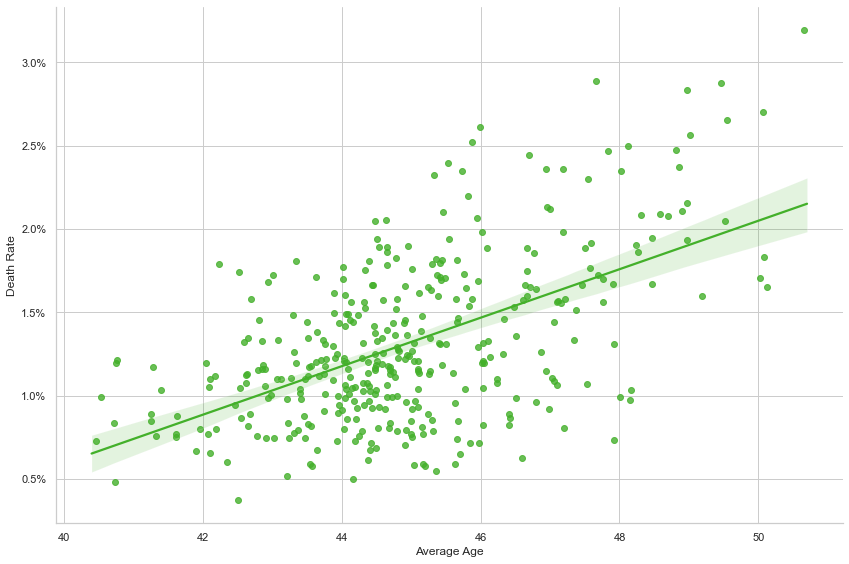

In [79]:
sns.set_style('whitegrid') 
ax=sns.lmplot(x="Avg_Age", y="death_rate",data=corona_counties,height=8, aspect=1.5, x_jitter=.1,scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'}) 
ax.set(xlabel='Average Age', ylabel='Death Rate')
ax.axes[0,0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1))

Plot the relationship between average age and landkreis for those landkreis whose infection rate are above median infection rate and 75% quantile value among all landkreis respectively

In [80]:
bad_landkreis=corona_counties.loc[corona_counties.infection_rate>corona_counties["infection_rate"].quantile(0.5),:]

worse_landkreis=corona_counties.loc[corona_counties.infection_rate>corona_counties["infection_rate"].quantile(0.75),:]

for landkreis whose infection rate above median infection rate among all landkreis:

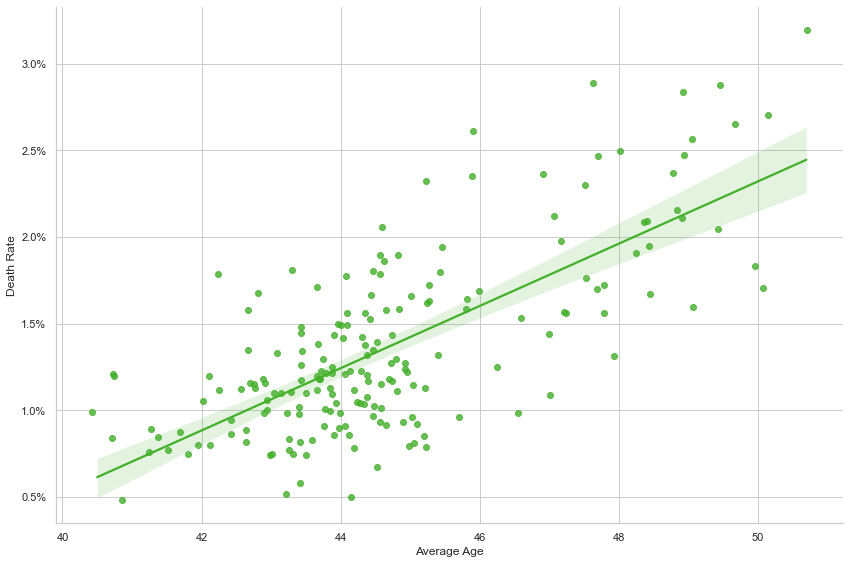

In [81]:
sns.set_style('whitegrid') 
ax=sns.lmplot(x="Avg_Age", y="death_rate",data=bad_landkreis,height=8, aspect=1.5, x_jitter=.1,scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'}) 
ax.set(xlabel='Average Age', ylabel='Death Rate')
ax.axes[0,0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1))

for landkreis whose infection rate above75% quantile among all landkreis:

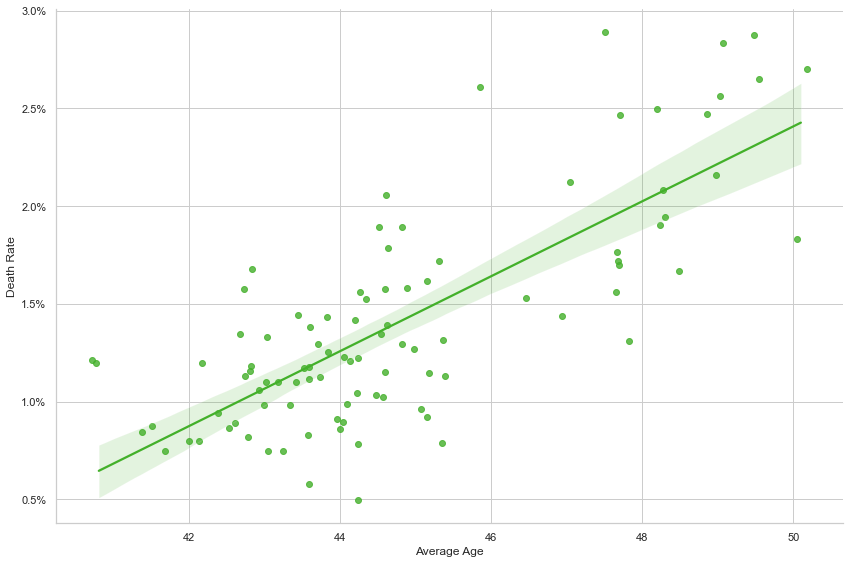

In [82]:
sns.set_style('whitegrid') 
ax=sns.lmplot(x="Avg_Age", y="death_rate",data=worse_landkreis,height=8, aspect=1.5, x_jitter=.1,scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'}) 
ax.set(xlabel='Average Age', ylabel='Death Rate')
ax.axes[0,0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1))

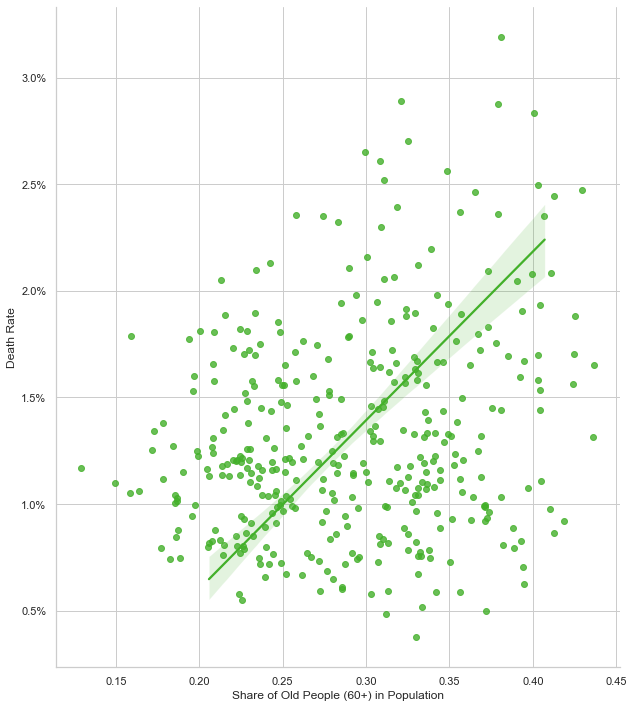

In [83]:
sns.set_style('whitegrid') 
ax=sns.lmplot(x="elder_ratio", y="death_rate",data=corona_counties,height=10, aspect=.9, x_jitter=.1,scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'}) 
ax.set(xlabel='Share of Old People (60+) in Population', ylabel='Death Rate')
ax.axes[0,0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1))


Plot the relationship between average age and infection rate for all landkreis

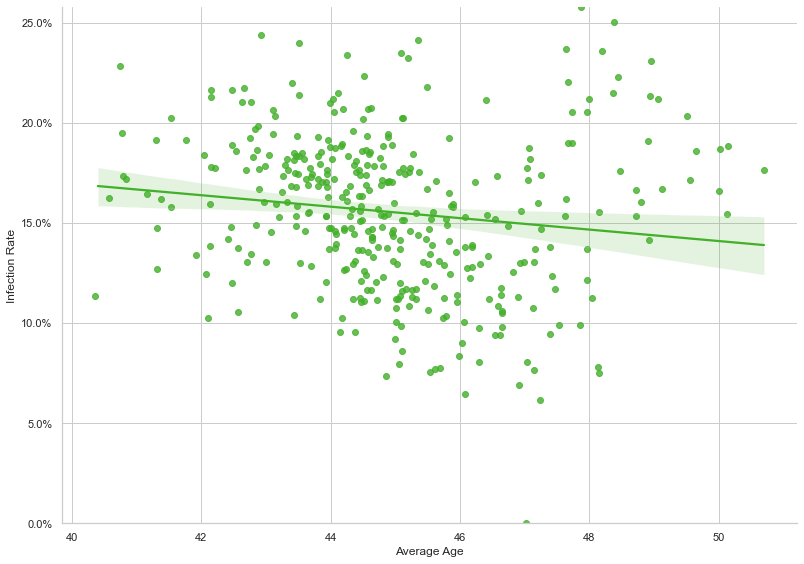

In [84]:
## sns.set_style('whitegrid')  
ax=sns.lmplot(x="Avg_Age", y="infection_rate",data=corona_counties,height=8, aspect=1.4, x_jitter=.1, scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'}) 
ax.set(xlabel='Average Age', ylabel='Infection Rate')
ax.set(ylim=(0, corona_counties.infection_rate.max()))
ax.axes[0,0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1))
ax.savefig("./"+output_filename+ "/infection_averageage_landkreis.png",dpi=800)

Plot the relationship between share of elderly people in the population and infection rate for all landkreis

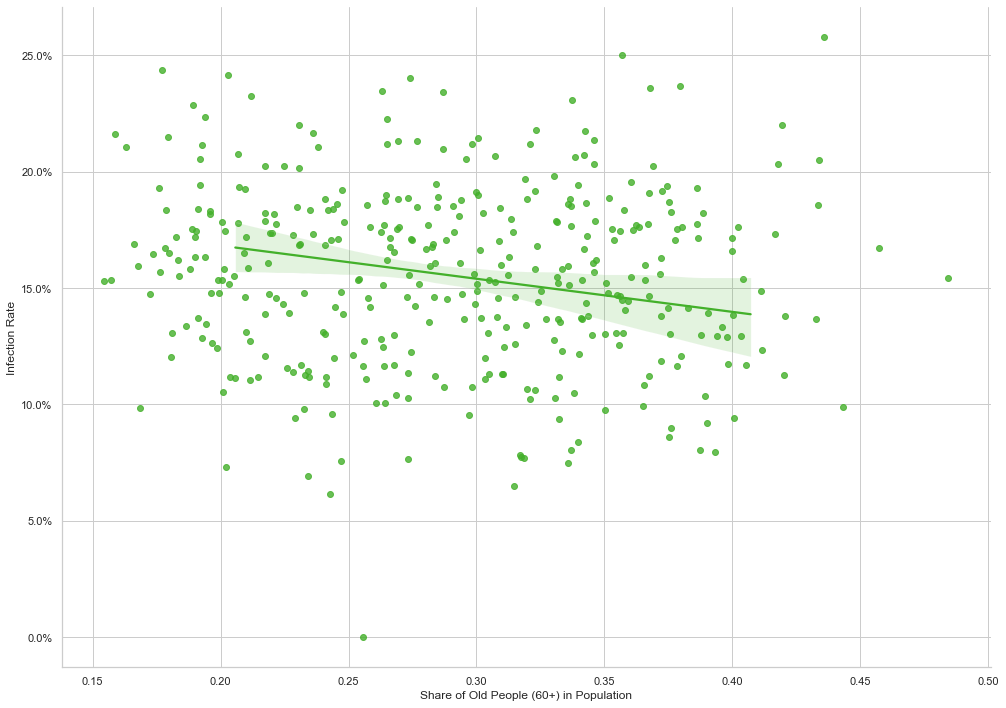

In [85]:
sns.set_style('whitegrid') 
ax=sns.lmplot(x="elder_ratio", y="infection_rate",data=corona_counties,height=10,aspect=1.4, x_jitter=.1, scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'}) 
ax.set(xlabel='Share of Old People (60+) in Population', ylabel='Infection Rate')
ax.axes[0,0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1))

### 3.4 Infection Rate and GDP per capita 

This section uses the dataframe created in section 3.3 "corona_counties" for analysis.


First check whether the maximal value for BIP je Berufstätige is a plausible value. 
Yes, that is correct, because it is Wolfsburg.

In [86]:
corona_counties.loc[corona_counties["BIP je Berufstätig"]==corona_counties["BIP je Berufstätig"].max(),:]

,Landkreis,Bundesland,Avg_Age,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,BIP je Kopf,BIP je Berufstätig,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
376,SK Wolfsburg,Niedersachsen,44.4,124151.0,61820.0,62331.0,7726.0,11755.0,15820.0,172437.0,163592.0,16096.0,12435.0,129.0,3532.0,0.010267,0.129649,0.284339


In [87]:
corona_counties.loc[corona_counties["infection_rate"]==corona_counties["infection_rate"].max(),:]

,Landkreis,Bundesland,Avg_Age,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,BIP je Kopf,BIP je Berufstätig,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
237,LK Sächsische Schweiz-Osterzgebirge,Sachsen,47.8,245611.0,121219.0,124392.0,18097.0,30281.0,37113.0,23040.0,55194.0,63349.0,53281.0,1347.0,8721.0,0.024658,0.257924,0.348075


The following Graph shows how infection rate associates with GDP per capita for German landkreis. In order to avoid the biased results, only landkreise whose GDP per capita is below 95% quantile of the gdps of all landkreise are shown in the graph.

In [88]:
corona_counties_wo_outlier=corona_counties.loc[corona_counties["BIP je Berufstätig"]<corona_counties["BIP je Berufstätig"].quantile(0.95)]

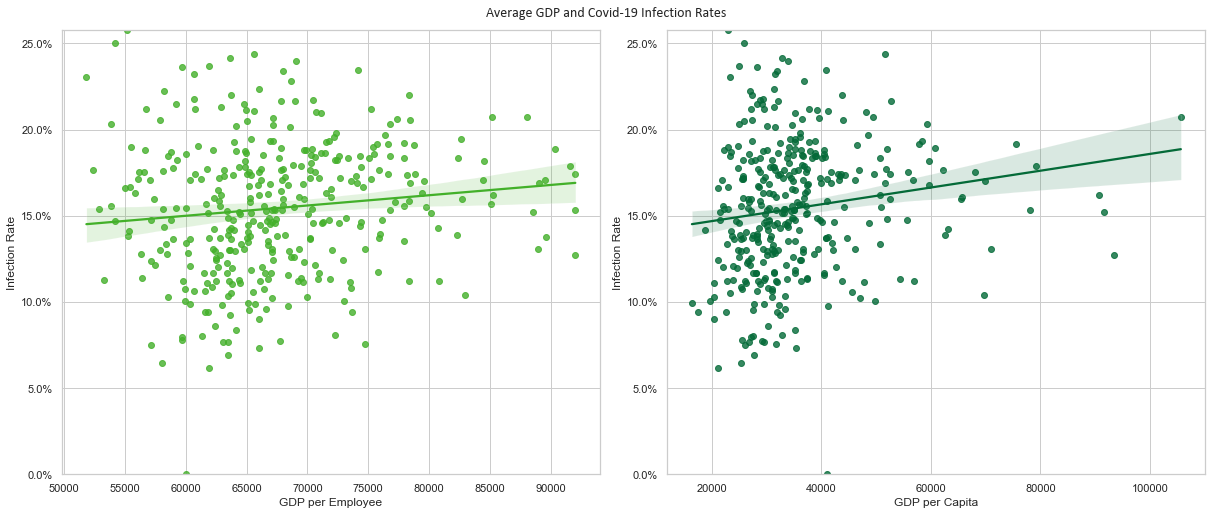

In [89]:
fig, axs = plt.subplots(ncols=2,figsize=(17,7))
sns.set_style('whitegrid') 

ax1=sns.regplot(x="BIP je Berufstätig", y="infection_rate",data=corona_counties_wo_outlier, ax=axs[0],scatter_kws={'color': '#43B02A'}, line_kws={'color': '#43B02A'})
ax1.set(xlabel="GDP per Employee", ylabel='Infection Rate')
ax1.set(ylim=(0, corona_counties_wo_outlier.infection_rate.max()))
ax1.axes.yaxis.set_major_formatter(PercentFormatter(1,decimals=1))


ax2=sns.regplot(x="BIP je Kopf", y="infection_rate",data=corona_counties_wo_outlier, ax=axs[1],scatter_kws={'color': '#046A38'}, line_kws={'color': '#046A38'})
ax2.set(xlabel="GDP per Capita", ylabel='Infection Rate')
ax2.set(ylim=(0, corona_counties_wo_outlier.infection_rate.max()))
ax2.yaxis.set_major_formatter(PercentFormatter(1,decimals=1))

plt.tight_layout()
fig.suptitle("Average GDP and Covid-19 Infection Rates", fontsize=14,fontname="Calibri",y=1.02)
fig.savefig("./"+output_filename +"/infection_gdp_landkreis.png",dpi=400)

### 3.5. Plotting Choropleth Maps with color bar: infection, Death, and landkreis-specific characteristics

there are two landkreis in the map with missing values in the map, namely LK Osterode am Harz and Bodensee. Bodensee is a water body. I will imputate values for the two landkreise. 

In [90]:
covid_counties=covid_landkreis.pivot_table(values=['AnzahlFall',"AnzahlTodesfall","AnzahlGenesen"],index=["Landkreis","ID","Bundesland","gesamt_popu","male_popu","female_popu",'60 bis unter 65 Jahre', '65 bis unter 75 Jahre', '75 Jahre und mehr'],aggfunc=sum).reset_index()
covid_counties.head(5)

,Landkreis,ID,Bundesland,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,AnzahlFall,AnzahlGenesen,AnzahlTodesfall
0,LK Ahrweiler,297,Rheinland-Pfalz,129727.0,63755.0,65972.0,9458.0,14696.0,17109.0,14515.0,9965.0,83.0
1,LK Aichach-Friedberg,46,Bayern,133596.0,66651.0,66945.0,8447.0,12853.0,13631.0,24258.0,19477.0,146.0
2,LK Alb-Donau-Kreis,1,Baden-Württemberg,196047.0,99041.0,97006.0,12811.0,17832.0,19888.0,34926.0,21024.0,213.0
3,LK Altenburger Land,381,Thüringen,90118.0,44138.0,45980.0,7665.0,12669.0,14672.0,16968.0,14009.0,389.0
4,LK Altenkirchen,298,Rheinland-Pfalz,128705.0,63859.0,64846.0,9255.0,13742.0,14952.0,15002.0,10229.0,119.0


In [91]:
covid_counties["AnzahlAktive"]=covid_counties["AnzahlFall"]-covid_counties["AnzahlGenesen"]-covid_counties["AnzahlTodesfall"]
covid_counties["death_rate"]=covid_counties["AnzahlTodesfall"]/(covid_counties["AnzahlFall"]-covid_counties["AnzahlAktive"])
covid_counties["infection_rate"]=covid_counties["AnzahlFall"]/covid_counties["gesamt_popu"]
covid_counties["elder_ratio"]=(covid_counties['60 bis unter 65 Jahre'] + covid_counties['65 bis unter 75 Jahre']+covid_counties['75 Jahre und mehr'])/covid_counties['gesamt_popu']
covid_counties.head()

,Landkreis,ID,Bundesland,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
0,LK Ahrweiler,297,Rheinland-Pfalz,129727.0,63755.0,65972.0,9458.0,14696.0,17109.0,14515.0,9965.0,83.0,4467.0,0.008260,0.111889,0.318076
1,LK Aichach-Friedberg,46,Bayern,133596.0,66651.0,66945.0,8447.0,12853.0,13631.0,24258.0,19477.0,146.0,4635.0,0.007440,0.181577,0.261467
2,LK Alb-Donau-Kreis,1,Baden-Württemberg,196047.0,99041.0,97006.0,12811.0,17832.0,19888.0,34926.0,21024.0,213.0,13689.0,0.010030,0.178151,0.257749
3,LK Altenburger Land,381,Thüringen,90118.0,44138.0,45980.0,7665.0,12669.0,14672.0,16968.0,14009.0,389.0,2570.0,0.027018,0.188286,0.388446
4,LK Altenkirchen,298,Rheinland-Pfalz,128705.0,63859.0,64846.0,9255.0,13742.0,14952.0,15002.0,10229.0,119.0,4654.0,0.011500,0.116561,0.294853


To plot the Choropleth Map for all landkreis in Germany, we have to provide data about all landkreise regarding infection rate, death rate and share of elderly in the population. "landkreise" is the dataframe created in section 3.1. containing all landkreise in Germany. Let us check whether the dataframe "covid_counties" contain all the landkreise in Germany

In [92]:
set(landkreise["Landkreis"]).difference(set(covid_counties["Landkreis"]))

{'Bodensee', 'LK Osterode am Harz'}

The two landkreis 'Bodensee', 'LK Osterode am Harz' are not included in dataset "covid_counties", therefore we imputate two extra rows of missing values for landkreis ID, death_rate, infection_rate and elder_ratio the two landreis using the corresponding bundesland averages to which they belong. The landkreis-specific ID will be used as joining key join the dataframe "covid_counties" with the geospatial dataset for the 403 Landkreis in Germany. The landkreis-specific ID for the landkreis can be found in the dataframe "landkreise" shown as below.

In [93]:
landkreise.loc[landkreise["Landkreis"]=="LK Osterode am Harz",:]

,Landkreis,Avg_Age,Avg_Age_M,Avg_Age_F,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Geo,ID,landkreis_ID,BIP je Kopf,BIP je Berufstätig
401,LK Osterode am Harz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"51.6779646607, 10.371446621",229,NaN,NaN,NaN


In [94]:
landkreise.loc[landkreise["Landkreis"]=="Bodensee",:]

,Landkreis,Avg_Age,Avg_Age_M,Avg_Age_F,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Geo,ID,landkreis_ID,BIP je Kopf,BIP je Berufstätig
402,Bodensee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"47.6320964263, 9.4070162375",6,NaN,NaN,NaN


The missing value for the two landkreis-specific infection rate, share of elderly population and death rate can replaced with their corresponding bundesland average rates.

In [95]:
state_ratio=covid_counties.pivot_table(values=["death_rate","infection_rate","elder_ratio"],index="Bundesland",aggfunc=np.mean)
state_ratio

,death_rate,elder_ratio,infection_rate
Bundesland,,,
Baden-Württemberg,0.011280,0.267308,0.171372
Bayern,0.012926,0.276393,0.183069
Berlin,0.008889,0.246621,0.186110
Brandenburg,0.016907,0.331611,0.184402
Bremen,0.009476,0.276631,0.162796
Hamburg,0.010516,0.234078,0.178106
Hessen,0.015376,0.278467,0.150299
Mecklenburg-Vorpommern,0.010828,0.328455,0.127753
Niedersachsen,0.010865,0.291932,0.109775


In [96]:
covid_counties.tail()

,Landkreis,ID,Bundesland,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
396,SK Worms,331,Rheinland-Pfalz,83330.0,41080.0,42250.0,5512.0,8246.0,8827.0,14019.0,9319.0,119.0,4581.0,0.012609,0.168235,0.271031
397,SK Wuppertal,296,Nordrhein-Westfalen,354382.0,173687.0,180695.0,22048.0,33801.0,39919.0,65501.0,50328.0,568.0,14605.0,0.011160,0.184832,0.270239
398,SK Würzburg,136,Bayern,127880.0,61151.0,66729.0,7048.0,11073.0,14440.0,22547.0,13466.0,153.0,8928.0,0.011234,0.176314,0.254622
399,SK Zweibrücken,332,Rheinland-Pfalz,34209.0,16954.0,17255.0,2440.0,3648.0,4268.0,3824.0,2180.0,12.0,1632.0,0.005474,0.111783,0.302727
400,StädteRegion Aachen,290,Nordrhein-Westfalen,555465.0,280162.0,275303.0,35182.0,53327.0,59259.0,91366.0,78191.0,704.0,12471.0,0.008923,0.164486,0.266026


I append two rows in the dataframe "covid_counties" in the row number 401 and 402.

In [97]:
covid_counties.loc[401,:]=["Bodensee", 6,"Baden-Württemberg",np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,state_ratio.loc["Baden-Württemberg","death_rate"],state_ratio.loc["Baden-Württemberg","infection_rate"],state_ratio.loc["Baden-Württemberg","elder_ratio"]]

In [98]:
covid_counties.loc[402,:]=["LK Osterode am Harz", 229,"Niedersachsen",np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,state_ratio.loc["Baden-Württemberg","death_rate"],state_ratio.loc["Niedersachsen","infection_rate"],state_ratio.loc["Niedersachsen","elder_ratio"]]

In [99]:
covid_counties.tail()

,Landkreis,ID,Bundesland,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
398,SK Würzburg,136.0,Bayern,127880.0,61151.0,66729.0,7048.0,11073.0,14440.0,22547.0,13466.0,153.0,8928.0,0.011234,0.176314,0.254622
399,SK Zweibrücken,332.0,Rheinland-Pfalz,34209.0,16954.0,17255.0,2440.0,3648.0,4268.0,3824.0,2180.0,12.0,1632.0,0.005474,0.111783,0.302727
400,StädteRegion Aachen,290.0,Nordrhein-Westfalen,555465.0,280162.0,275303.0,35182.0,53327.0,59259.0,91366.0,78191.0,704.0,12471.0,0.008923,0.164486,0.266026
401,Bodensee,6.0,Baden-Württemberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011280,0.171372,0.267308
402,LK Osterode am Harz,229.0,Niedersachsen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011280,0.109775,0.291932


check if there is any missing value in column "death_rate", "infection_rate", and "elder_ratio". This is important because we are going to draw Choropleth Map for infection rate, death rate and elder ratios for all 403 German landkreis. 

In [100]:
covid_counties.isnull().sum()

Landkreis                0
ID                       0
Bundesland               0
gesamt_popu              2
male_popu                2
female_popu              2
60 bis unter 65 Jahre    2
65 bis unter 75 Jahre    2
75 Jahre und mehr        2
AnzahlFall               2
AnzahlGenesen            2
AnzahlTodesfall          2
AnzahlAktive             2
death_rate               1
infection_rate           0
elder_ratio              0
dtype: int64

In [101]:
covid_counties.loc[covid_counties["death_rate"].isnull(),:]

,Landkreis,ID,Bundesland,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
319,SK Eisenach,383.0,Thüringen,42370.0,20874.0,21496.0,2956.0,4734.0,6231.0,0.0,0.0,0.0,0.0,NaN,0.0,0.328558


In [102]:
covid_counties.loc[319,"death_rate"]= state_ratio.loc["Thüringen","death_rate"]
covid_counties.loc[319,"infection_rate"]= state_ratio.loc["Thüringen","infection_rate"]
covid_counties.loc[319,"elder_ratio"]= state_ratio.loc["Thüringen","elder_ratio"]

Read the geo_spatial data for all 403 German Landkreise, these data will be firstly merged with above mentioned "covid_counties" dataset and then used to prepare the Choropleth Map. The dataset "landkreise-in-Germany" comes from the following website: https://data.opendatasoft.com/explore/dataset/georef-germany-kreis%40public/export/?disjunctive.lan_code&disjunctive.lan_name&disjunctive.krs_code&disjunctive.krs_name&disjunctive.krs_name_short

In [103]:

map_df = gpd.read_file("landkreise-in-germany.geojson")
map_df.head()

,name_2,name_0,name_1,type_2,engtype_2,hasc_2,id_2,cca_2,id_0,id_1,iso,ccn_2,varname_2,geometry
0,Freiburg im Breisgau,Germany,Baden-Württemberg,Stadtkreis,District,DE.BW.FB,12,08311,86,1,DEU,0,None,"POLYGON ((7.79045 47.96881, 7.78610 47.96866, ..."
1,Dillingen an der Donau,Germany,Bayern,Landkreis,District,DE.BY.DD,68,09773,86,2,DEU,0,None,"POLYGON ((10.61448 48.75084, 10.61411 48.74994..."
2,Nürnberg,Germany,Bayern,Kreisfreie Stadt,District,DE.BY.NR,107,09564,86,2,DEU,0,None,"MULTIPOLYGON (((11.18831 49.38963, 11.18645 49..."
3,Neumarkt in der Oberpfalz,Germany,Bayern,Landkreis,District,DE.BY.NO,110,09373,86,2,DEU,0,None,"POLYGON ((11.46063 49.42604, 11.46161 49.42276..."
4,Rosenheim,Germany,Bayern,Kreisfreie Stadt,District,DE.BY.RH,122,09163,86,2,DEU,0,None,"POLYGON ((12.05431 47.81771, 12.05556 47.81853..."


The dataframe named "merged" will be used to draw Choropleth Maps

In [104]:
merged = map_df.set_index("id_2").join(covid_counties.set_index("ID"))
merged.head()

,name_2,name_0,name_1,type_2,engtype_2,hasc_2,cca_2,id_0,id_1,iso,ccn_2,varname_2,geometry,Landkreis,Bundesland,gesamt_popu,male_popu,female_popu,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,AnzahlFall,AnzahlGenesen,AnzahlTodesfall,AnzahlAktive,death_rate,infection_rate,elder_ratio
id_2,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,Freiburg im Breisgau,Germany,Baden-Württemberg,Stadtkreis,District,DE.BW.FB,08311,86,1,DEU,0,None,"POLYGON ((7.79045 47.96881, 7.78610 47.96866, ...",SK Freiburg i.Breisgau,Baden-Württemberg,230241.0,109829.0,120412.0,12058.0,17789.0,20189.0,37352.0,22024.0,220.0,15108.0,0.009890,0.162230,0.217320
68,Dillingen an der Donau,Germany,Bayern,Landkreis,District,DE.BY.DD,09773,86,2,DEU,0,None,"POLYGON ((10.61448 48.75084, 10.61411 48.74994...",LK Dillingen a.d.Donau,Bayern,96021.0,48135.0,47886.0,6672.0,9386.0,9949.0,17795.0,12637.0,184.0,4974.0,0.014351,0.185324,0.270847
107,Nürnberg,Germany,Bayern,Kreisfreie Stadt,District,DE.BY.NR,09564,86,2,DEU,0,None,"MULTIPOLYGON (((11.18831 49.38963, 11.18645 49...",SK Nürnberg,Bayern,518365.0,252807.0,265558.0,29548.0,48093.0,55960.0,105465.0,85429.0,1153.0,18883.0,0.013317,0.203457,0.257735
110,Neumarkt in der Oberpfalz,Germany,Bayern,Landkreis,District,DE.BY.NO,09373,86,2,DEU,0,None,"POLYGON ((11.46063 49.42604, 11.46161 49.42276...",LK Neumarkt i.d.OPf.,Bayern,133561.0,67499.0,66062.0,9079.0,12423.0,12988.0,24696.0,18340.0,218.0,6138.0,0.011747,0.184904,0.258234
122,Rosenheim,Germany,Bayern,Kreisfreie Stadt,District,DE.BY.RH,09163,86,2,DEU,0,None,"POLYGON ((12.05431 47.81771, 12.05556 47.81853...",SK Rosenheim,Bayern,63324.0,31321.0,32003.0,3454.0,6091.0,6641.0,15439.0,10366.0,111.0,4962.0,0.010595,0.243810,0.255606


#### 3.5.1 Choropleth Map for share of elderly people and infection rate per landkreis

The following map show the share of old people (with age above 60) in the population for each landkreis.

C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


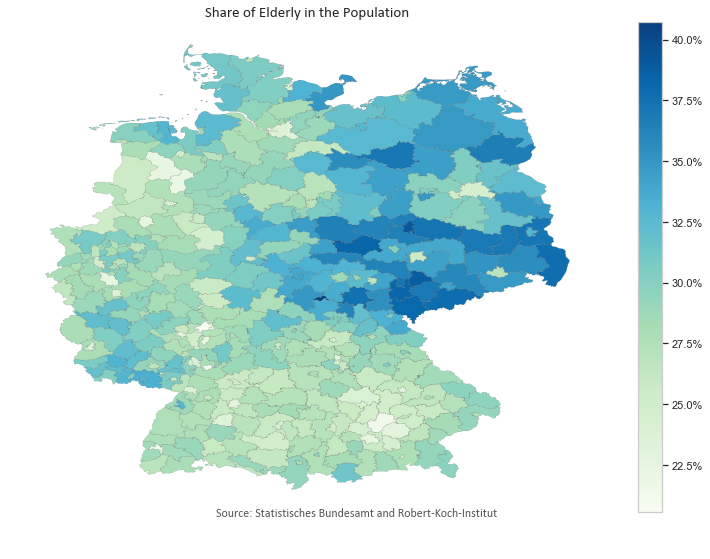

In [105]:

variable = "elder_ratio"

fig,ax = plt.subplots(1, figsize=(15, 9))


merged.plot(column=variable, cmap="GnBu", linewidth=0.1, ax=ax, edgecolor="0.2")

#ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))

ax.axis("off")  


ax.set_title("Share of Elderly in the Population", fontdict={"fontsize": "15", "fontweight" : "regular","fontname":'Calibri'})
# create an annotation for the data source

ax.annotate("Source: Statistisches Bundesamt and Robert-Koch-Institut",xy=(0.2, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")


# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="GnBu", norm=plt.Normalize(vmin=covid_counties.elder_ratio.min(), vmax=covid_counties.elder_ratio.max()))


sm._A = []

# add the colorbar to the figure

cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=1))

plt.savefig("./"+output_filename+"/map_old_DE.png",dpi=400)

The following map shows the infection rate (number of cases divided by the population) for each landkreis in the German map.

C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


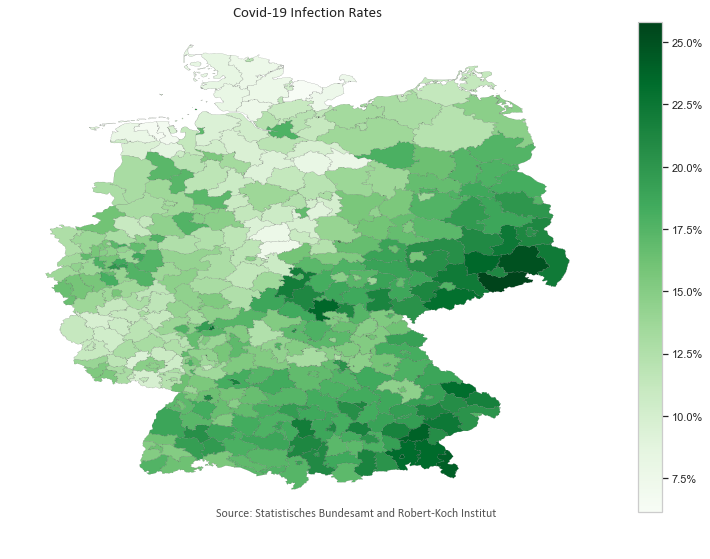

In [106]:
# from matplotlib import pyplot as plt

# set a variable that will call whatever column we want to visualise on the map
variable = "infection_rate"

fig,ax = plt.subplots(1, figsize=(15, 9))

merged.plot(column=variable, cmap="Greens", linewidth=0.1, ax=ax, edgecolor="0.2")

ax.axis("off")  

ax.set_title("Covid-19 Infection Rates", fontdict={"fontsize": "15", "fontweight" : "regular","fontname":'Calibri'})
# create an annotation for the data source

ax.annotate("Source: Statistisches Bundesamt and Robert-Koch Institut",xy=(0.2, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")


# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=covid_counties.infection_rate.min(), vmax=covid_counties.infection_rate.max()))



sm._A = []


cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=1))


plt.savefig("./"+output_filename+"/map_infection_DE.png",dpi=400)

#####  merge the two Choropleth Maps for share of elderly people and infection rate into one Choropleth Map

C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


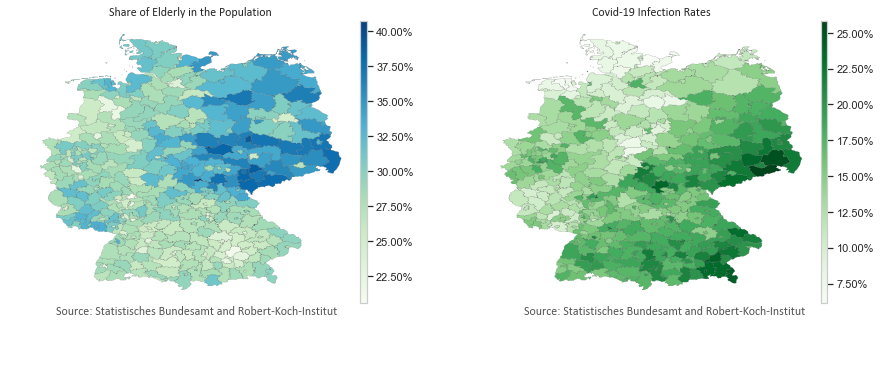

In [108]:
fig, axs = plt.subplots(ncols=2,figsize=(13,7))

######### add the first map

variable = "elder_ratio"

ax1=merged.plot(column=variable, cmap="GnBu", linewidth=0.1, ax=axs[0], edgecolor="0.2")

ax1.axis("off")  

ax1.set_title("Share of Elderly in the Population", fontdict={"fontsize": "12", "fontweight" : "regular","fontname":'Calibri'})

ax1.annotate("Source: Statistisches Bundesamt and Robert-Koch-Institut",xy=(0.06, .13),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")

# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="GnBu", norm=plt.Normalize(vmin=covid_counties.elder_ratio.min(), vmax=covid_counties.elder_ratio.max()))

sm._A = []

# add the colorbar to the figure

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=2),ax=axs[0],cax = cax1)

#############add the second map

variable = "infection_rate"

ax2=merged.plot(column=variable, cmap="Greens", linewidth=0.1, ax=axs[1], edgecolor="0.2")

ax2.axis("off")  

ax2.set_title("Covid-19 Infection Rates", fontdict={"fontsize": "12", "fontweight" : "regular","fontname":'Calibri'})
# create an annotation for the data source

ax2.annotate("Source: Statistisches Bundesamt and Robert-Koch-Institut",xy=(0.56, .13),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")



# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=covid_counties.infection_rate.min(), vmax=covid_counties.infection_rate.max()))

sm._A = []

# add the colorbar to the figure
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=2),ax=axs[1],cax = cax2)

plt.tight_layout(w_pad = 6)


fig.savefig("./"+output_filename+"/map_infection_old.png",bbox_inches = 'tight',dpi=400)

#### 3.5.2 Choropleth Map for share of elderly people and death rate per landkreis

The following map shows the infection rate (number of deaths divided by the number of covid cases) for each landkreis in the German map.

C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


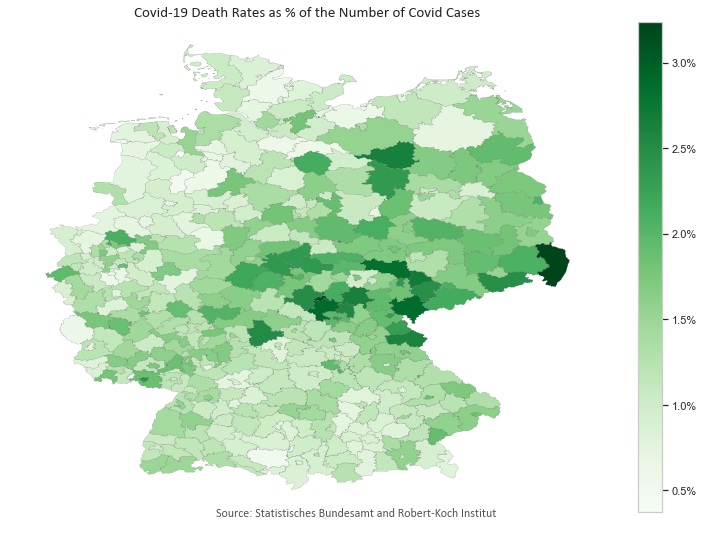

In [109]:
variable = "death_rate"

fig,ax = plt.subplots(1, figsize=(15, 9))

merged.plot(column=variable, cmap="Greens", linewidth=0.1, ax=ax, edgecolor="0.2")

ax.axis("off")  

ax.set_title("Covid-19 Death Rates as % of the Number of Covid Cases", fontdict={"fontsize": "15", "fontweight" : "regular","fontname":'Calibri'})
# create an annotation for the data source

ax.annotate("Source: Statistisches Bundesamt and Robert-Koch Institut",xy=(0.2, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")


# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=covid_counties.death_rate.min(), vmax=covid_counties.death_rate.max()))



sm._A = []


cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=1))


plt.savefig("./"+output_filename+"/map_death_DE.png",dpi=400)

#####  merge the two Choropleth Maps for share of elderly people and death rate into one Choropleth Map

C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\kanhf\anaconda3\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


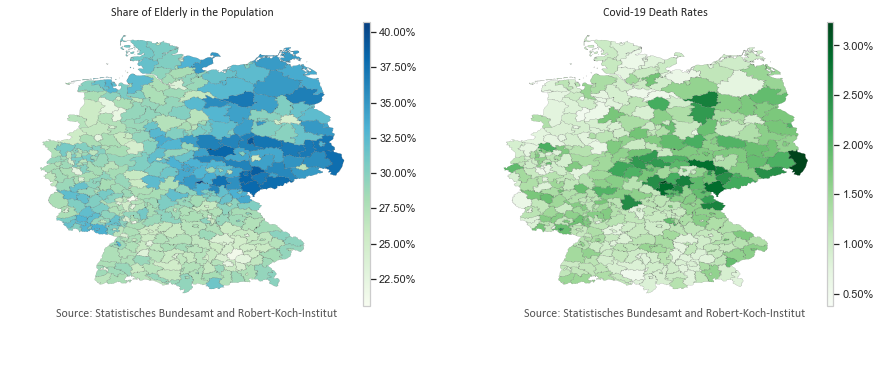

In [110]:
fig, axs = plt.subplots(ncols=2,figsize=(13,7))

######### add the first map

variable = "elder_ratio"

ax1=merged.plot(column=variable, cmap="GnBu", linewidth=0.1, ax=axs[0], edgecolor="0.2")

ax1.axis("off")  

ax1.set_title("Share of Elderly in the Population", fontdict={"fontsize": "12", "fontweight" : "regular","fontname":'Calibri'})

ax1.annotate("Source: Statistisches Bundesamt and Robert-Koch-Institut",xy=(0.06, .13),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")

# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="GnBu", norm=plt.Normalize(vmin=covid_counties.elder_ratio.min(), vmax=covid_counties.elder_ratio.max()))

sm._A = []

# add the colorbar to the figure

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=2),ax=axs[0],cax = cax1)

#############add the second map

variable = "death_rate"

ax2=merged.plot(column=variable, cmap="Greens", linewidth=0.1, ax=axs[1], edgecolor="0.2")

ax2.axis("off")  

ax2.set_title("Covid-19 Death Rates", fontdict={"fontsize": "12", "fontweight" : "regular","fontname":'Calibri'})
# create an annotation for the data source

ax2.annotate("Source: Statistisches Bundesamt and Robert-Koch-Institut",xy=(0.56, .13),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, fontname='Calibri',color="#555555")



# Create colorbar as a legend

sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=covid_counties.death_rate.min(), vmax=covid_counties.death_rate.max()))

sm._A = []

# add the colorbar to the figure
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(sm,format=PercentFormatter(1,decimals=2),ax=axs[1],cax = cax2)

plt.tight_layout(w_pad = 6)


fig.savefig("./"+output_filename+"/map_death_old.png",bbox_inches = 'tight',dpi=400)